In [1]:
import torch
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import sklearn as sk
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, VECM
import statsmodels.tsa.vector_ar.vecm as vecm 
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.vector_ar.util as var_tool
from pandarallel import pandarallel
from multiprocessing import Pool
import tqdm
import pickle
import itertools
from collections import defaultdict, OrderedDict

from help_function import *

pandarallel.initialize(progress_bar=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
price_df = pd.read_csv("data/price/aggregated_price.csv", index_col='blockNum')
price_df = price_df[['chainlink_usd_eth', 'uniswap_v3_usdc_eth_005', 'maker_dao_median_usd_eth', 'binance_usdc_eth']]
log_price_df = np.log(price_df)
log_f_diff = log_price_df.diff().dropna()
print(price_df.columns, price_df.shape)
price_df

Index(['chainlink_usd_eth', 'uniswap_v3_usdc_eth_005',
       'maker_dao_median_usd_eth', 'binance_usdc_eth'],
      dtype='object') (1860041, 4)


,chainlink_usd_eth,uniswap_v3_usdc_eth_005,maker_dao_median_usd_eth,binance_usdc_eth
blockNum,,,,
12980001,3065.955606,3076.686515,3043.0,3083.313889
12980002,3065.955606,3076.686515,3043.0,3086.408235
12980003,3065.955606,3076.686515,3043.0,3081.612000
12980004,3065.955606,3076.686515,3043.0,3077.450000
12980005,3065.955606,3080.394993,3043.0,3080.896667
...,...,...,...,...
14839996,1974.592132,2003.697706,2010.5,2006.925000
14839997,1974.592132,2003.702396,2010.5,2006.950000
14839998,1974.592132,2003.702396,2010.5,2006.950000


In [24]:
price_df.loc[13140870:13140875,:]

,chainlink_usd_eth,uniswap_v3_usdc_eth_005,maker_dao_median_usd_eth,binance_usdc_eth
blockNum,,,,
13140870,3610.145889,3655.461341,3592.92,3667.346923
13140871,3610.145889,3655.461341,3592.92,3670.284667
13140872,3610.145889,3658.446959,3592.92,3664.760000
13140873,3610.145889,3658.446959,3592.92,3665.735294
13140874,3610.920052,3658.446959,3592.92,3662.109000
13140874,3630.656507,3658.446959,3592.92,3662.109000
13140875,3655.501180,3657.193433,3592.92,3661.139000


In [28]:
ttt = log_f_diff[log_f_diff['chainlink_usd_eth'] != 0.0]['chainlink_usd_eth']
t2 = pd.DataFrame(ttt.index, index=ttt.index).diff()
t2[t2['blockNum'] == 0.0]

,blockNum
blockNum,
13005631,0.0
13140874,0.0
13159304,0.0
13177597,0.0
13179410,0.0
13209825,0.0
13217674,0.0
13217777,0.0
13460759,0.0


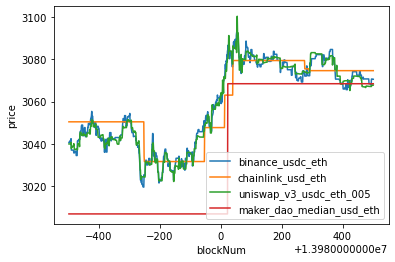

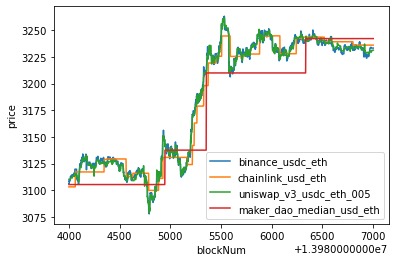

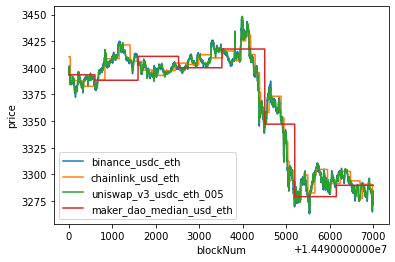

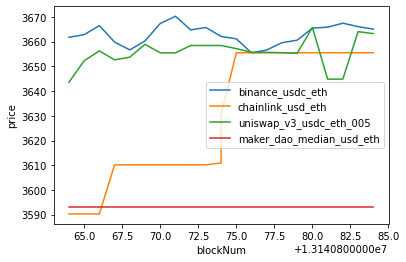

In [22]:
def plot_df(price_df, index_from=0, index_to=-1, plot_full=False, 
            plot_col_str=None):
    if not plot_full:
        price_df = price_df.loc[index_from:index_to, :]
    fig,ax = plt.subplots()

    loop_iter = plot_col_str.split(' ') if plot_col_str is not None else price_df.columns

    for name in loop_iter:
        ax.plot(price_df.index, price_df[name],label=name)

    ax.set_xlabel("blockNum")
    ax.set_ylabel("price")
    ax.legend(loc='best')

plot_col_str='binance_usdc_eth chainlink_usd_eth uniswap_v3_usdc_eth_005 maker_dao_median_usd_eth'
plot_df(price_df, 13980001-500, 13980001+500, plot_col_str=plot_col_str)
plot_df(price_df, 13980001+4000, 13980001+7000, plot_col_str=plot_col_str)
plot_df(price_df, 13980001+510000, 13980001+517000, plot_col_str=plot_col_str)
plot_df(price_df, 13140874-10, 13140874+10, plot_col_str=plot_col_str)

# 1. Overall Latency (1 year) - VAR model

due to the insufficient RAM in Computer

## 1.1 Lag Selection
The result indicated that the best lags = 100, which mean it is greater than 100. For simplicity, we use 100 instead

In [4]:
model = VAR(log_f_diff)
test = model.fit(maxlags=100)

/Users/anl/opt/anaconda3/envs/test2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## 1.2 VAR model estimation

In [5]:
model = VAR(log_f_diff)
lag_num = 100
fitted_model = model.fit(lag_num)
with open(f"./data/analysis/full_data_var.pickle", "wb") as fp:
    pickle.dump(fitted_model, fp)

/Users/anl/opt/anaconda3/envs/test2/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### 1.2.1 Test Granger Causality

In [6]:
with open(f"./data/analysis/full_data_var.pickle", "rb") as fp:
    fitted_model = pickle.load(fp)

In [7]:
from_var = 'uniswap'
to_var = 'chainlink_usd_eth'

lag_i = [int(i.split('.')[0][1:]) for i in fitted_model.params[to_var].index if from_var in i]
params = [fitted_model.params.loc[i,to_var] for i in fitted_model.params[to_var].index if from_var in i]
params = list(map(lambda x: x/np.sum(params), params))

np.sum([i*j for i,j in zip(lag_i, params)])

54.81952035033925

<AxesSubplot:>

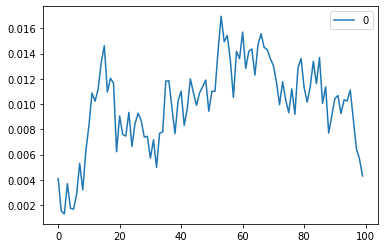

In [8]:
pd.DataFrame(params).plot()

In [9]:
fitted_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, Jul, 2022
Time:                     01:54:37
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -61.0600
Nobs:                 1.85994e+06    HQIC:                  -61.0678
Log likelihood:       4.62390e+07    FPE:                3.00140e-27
AIC:                     -61.0707    Det(Omega_mle):     2.99881e-27
--------------------------------------------------------------------
Results for equation chainlink_usd_eth
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                -0.000000         0.000000           -0.192           0.848
L1.chainlink_usd_eth                 -0.031318         0.000733          -42.707 

In [10]:
for var_i in price_df.columns:
    for var_j in price_df.columns:
        if var_i == var_j: continue
        test_result = fitted_model.test_causality(caused = var_i,causing = var_j)
        if test_result.pvalue < 0.05:
            print(f"{var_i} -> {var_j}")
        # print(test_result.summary())

chainlink_usd_eth -> uniswap_v3_usdc_eth_005
chainlink_usd_eth -> maker_dao_median_usd_eth
chainlink_usd_eth -> binance_usdc_eth
uniswap_v3_usdc_eth_005 -> chainlink_usd_eth
uniswap_v3_usdc_eth_005 -> maker_dao_median_usd_eth
uniswap_v3_usdc_eth_005 -> binance_usdc_eth
maker_dao_median_usd_eth -> chainlink_usd_eth
maker_dao_median_usd_eth -> uniswap_v3_usdc_eth_005
maker_dao_median_usd_eth -> binance_usdc_eth
binance_usdc_eth -> chainlink_usd_eth
binance_usdc_eth -> uniswap_v3_usdc_eth_005
binance_usdc_eth -> maker_dao_median_usd_eth


## 1.3 Implus Respond Function

In [2]:
with open(f"./data/analysis/full_data_var.pickle", "rb") as fp:
    fitted_model = pickle.load(fp)

In [3]:
irf_periods = 300
irf_result = fitted_model.irf(irf_periods)

### 1.3.1 Weighted Average Latency

In [6]:
get_model_irf_df(fitted_model, irf_periods, log_f_diff.columns, return_data='weighted_avg_latency').round(2)

---- index = implus source, column = implus to ----


,chainlink_usd_eth,uniswap_v3_usdc_eth_005,maker_dao_median_usd_eth,binance_usdc_eth
chainlink_usd_eth,3.18,51.73,36.14,38.08
uniswap_v3_usdc_eth_005,36.31,6.55,57.82,11.15
maker_dao_median_usd_eth,46.27,47.35,1.34,47.34
binance_usdc_eth,31.25,10.65,52.02,3.63


### 1.3.2 Cummulative Effect

In [34]:
get_model_irf_df(fitted_model, irf_periods, log_f_diff.columns, return_data='cum_effect').round(5)

---- index = implus source, column = implus to ----


,chainlink_usd_eth,uniswap_v3_usdc_eth_005,maker_dao_median_usd_eth,binance_usdc_eth
chainlink_usd_eth,0.00041,0.00004,0.00010,0.00002
uniswap_v3_usdc_eth_005,0.00032,0.00065,0.00021,0.00035
maker_dao_median_usd_eth,0.00002,0.00004,0.00052,0.00002
binance_usdc_eth,0.00037,0.00041,0.00026,0.00050


### 1.3.3 irf plot

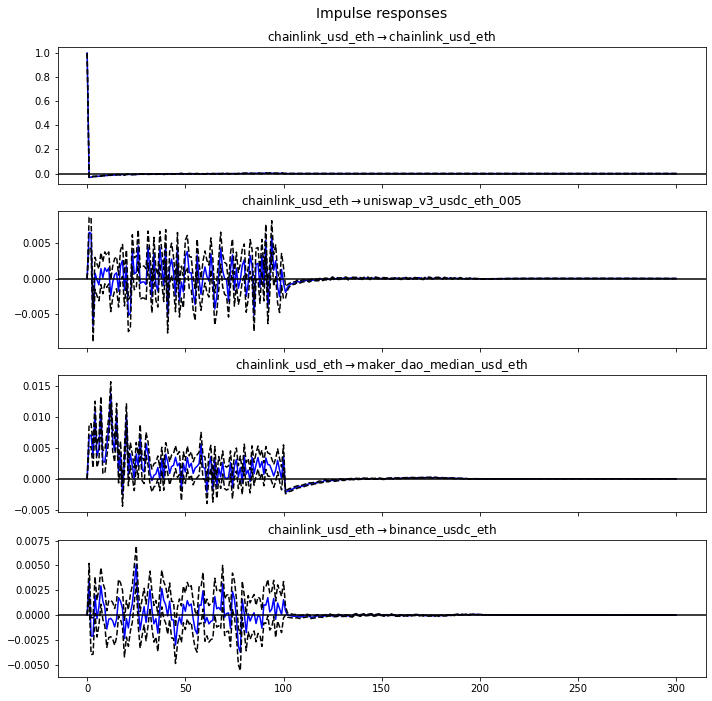

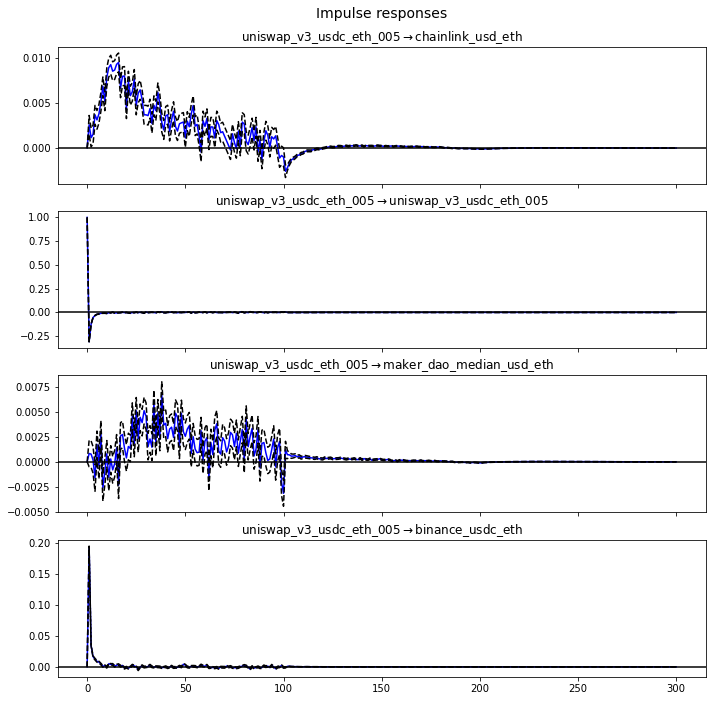

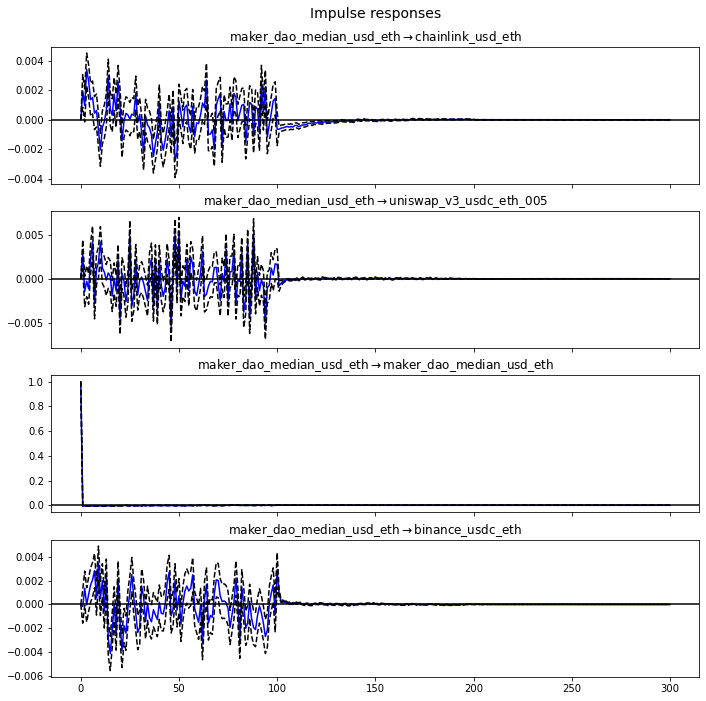

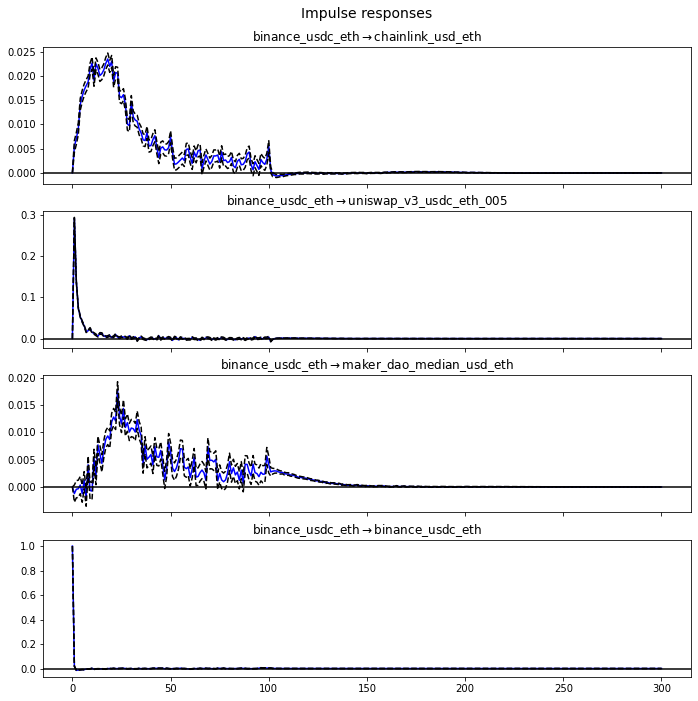

In [35]:
irf_result.plot(impulse='chainlink_usd_eth')
irf_result.plot(impulse='uniswap_v3_usdc_eth_005')
irf_result.plot(impulse='maker_dao_median_usd_eth')
irf_result.plot(impulse='binance_usdc_eth')
_ = 0

### 1.3.4 irf cummulative plot

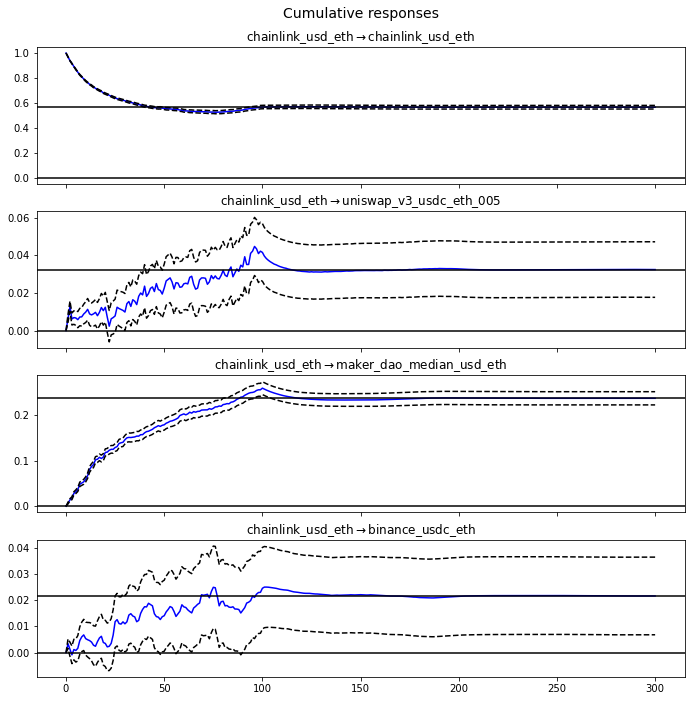

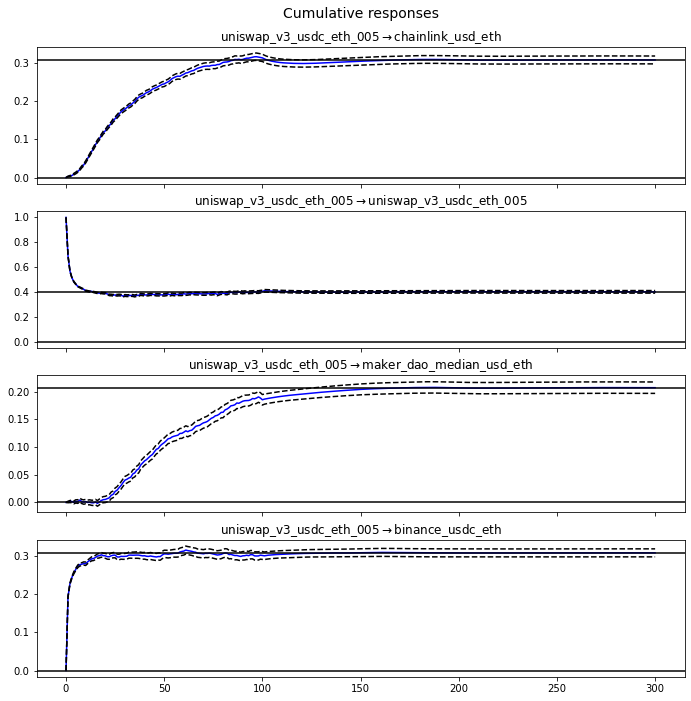

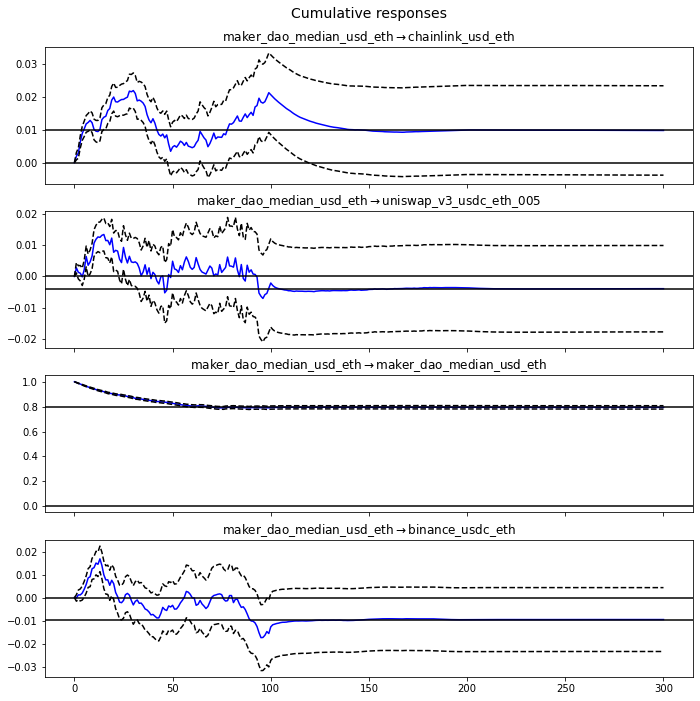

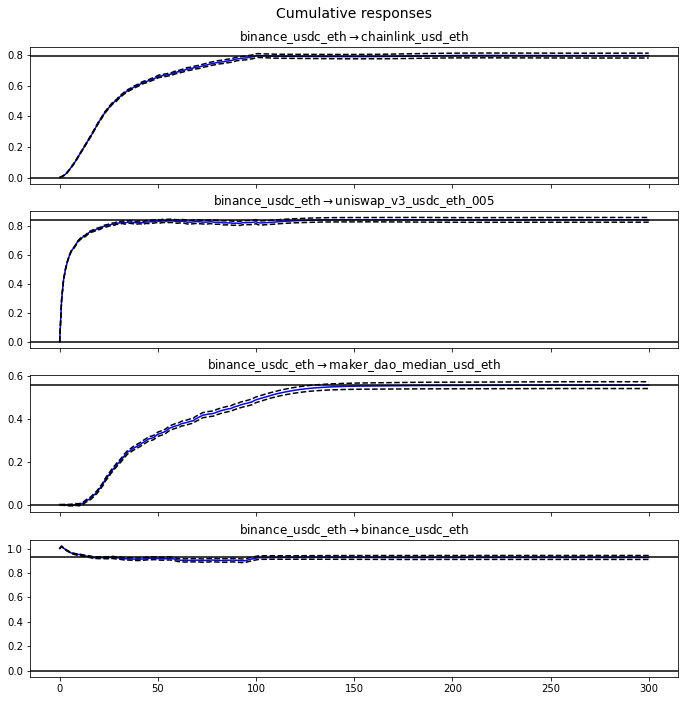

In [36]:
irf_result.plot_cum_effects(impulse='chainlink_usd_eth')
irf_result.plot_cum_effects(impulse='uniswap_v3_usdc_eth_005')
irf_result.plot_cum_effects(impulse='maker_dao_median_usd_eth')
irf_result.plot_cum_effects(impulse='binance_usdc_eth')
_ = 0

# 2. Per 6424 block inspectation

In [ ]:
14840000	 - 12980001

In [ ]:
log_price_df


In [ ]:
# tt = pd.DataFrame(list(range(log_price_df.index[0], log_price_df.index[-1]+1)), columns=['blockNum']).merge(log_price_df, how='left', on='blockNum').set_index('blockNum')
# tt

In [17]:
avg_block_per_day = 6424
sub_split_size = avg_block_per_day

split_num = 6
df_split_each_range = avg_block_per_day * split_num

In [18]:
# split_num_list = [(i+1)*40000 for i in range(log_price_df.shape[0]//40000)] +  [(log_price_df.shape[0]//40000)*40000 + log_price_df.shape[0] % 40000]

# Log data
p_value_result_list = []
log_diff_p_value_result_list = []

# 2 model
fitted_var_model_list = []
fitted_vecm_model_list = []

# sub_split_size = 10000

start_block_num_list = []
end_block_num_list = []

# for tmp_log_price_df in tqdm.tqdm(np.split(log_price_df, split_num_list)):
for tmp_log_price_df in tqdm.tqdm(np.split(log_price_df, df_split_index(log_price_df, each_range=df_split_each_range))):
    if len(tmp_log_price_df.index) == 0: continue
    start_block_num_list.append(tmp_log_price_df.index[0])
    end_block_num_list.append(tmp_log_price_df.index[-1])

    tmp_log_price_df = tmp_log_price_df.reset_index(drop=True)
    
    # print(f'size of df {tmp_log_price_df.shape}')

    # test stationary
    p_value_result = tmp_log_price_df.parallel_apply(my_adfuller_p_value, axis=0)
    p_value_result_list.append(pd.DataFrame(p_value_result, columns=['p_value']))
    # make stationary
    log_f_diff = tmp_log_price_df.diff().dropna() 
    log_f_diff = log_f_diff.reset_index(drop=True)
    log_diff_p_value_result = log_f_diff.parallel_apply(my_adfuller_p_value, axis=0)
    log_diff_p_value_result_list.append(pd.DataFrame(log_diff_p_value_result, columns=['p_value']))
    
    # VAR model
    fitted_model_result = main_multi_p(log_f_diff, split_num=split_num, model='var')
    fitted_var_model_list.append(fitted_model_result)

    # VECM model
    fitted_model_result = main_multi_p(tmp_log_price_df, split_num=split_num, model='vecm')
    fitted_vecm_model_list.append(fitted_model_result)


save_data = [
    start_block_num_list,
    end_block_num_list,
    p_value_result_list,
    log_diff_p_value_result_list,
    fitted_var_model_list,
    fitted_vecm_model_list
]

with open("./data/analysis/horizontal/splitted_data_models.pickle", "wb") as output_file:
    pickle.dump(save_data, output_file)

 96%|█████████▌| 48/50 [1:17:47<02:43, 81.76s/it] 

add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns
add random to avoid constant columns


100%|██████████| 50/50 [1:18:24<00:00, 94.10s/it]


In [1]:
# log_f_diff

NameError: name 'log_f_diff' is not defined

In [ ]:
# save_data = [
#     start_block_num_list,
#     end_block_num_list,
#     p_value_result_list,
#     log_diff_p_value_result_list,
#     fitted_var_model_list,
#     fitted_vecm_model_list
# ]


# with open("./data/analysis/splitted_data_models.pickle", "wb") as output_file:
#     pickle.dump(save_data, output_file)

In [19]:
with open("./data/analysis/horizontal/splitted_data_models.pickle", "rb") as output_file:
    start_block_num_list,end_block_num_list,p_value_result_list,log_diff_p_value_result_list,fitted_var_model_list,fitted_vecm_model_list = pickle.load(output_file)
fitted_var_models =[]
fitted_vecm_models = []
for var_list, vecm_list in zip(fitted_var_model_list,fitted_vecm_model_list):
    for var_i, vecm_i in zip(var_list, vecm_list):
        fitted_var_models.append(var_i)
        fitted_vecm_models.append(vecm_i)
del fitted_var_model_list, fitted_vecm_model_list

      chainlink_usd_eth  maker_dao_median_usd_eth
mean          14.975794                 15.518845
std           11.631496                 12.903903


<AxesSubplot:>

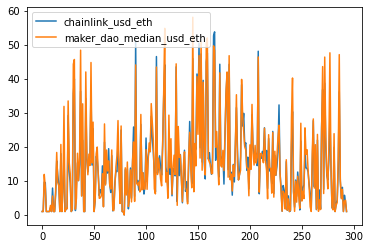

In [41]:
def get_latency_df(fitted_var_models, source_var, target_var):
    latency_list = []
    for model_i in range(len(fitted_var_models)):
        model_para = fitted_var_models[model_i].params
        lag_order = [int(i.split(".")[0][1:]) for i in model_para[target_var].index if source_var in i]
        coef = [model_para[target_var].loc[i] for i in model_para[target_var].index if source_var in i]
        coef_weight = list(map(lambda x: np.abs(x)/np.sum(np.abs(coef)), coef))
        latency_i = np.sum([i*j for i,j in zip(lag_order, coef_weight)])
        latency_list.append(latency_i)
    return pd.DataFrame(latency_list, columns=[target_var])
latency_chainlink = get_latency_df(fitted_var_models, source_var="uniswap_v3_usdc_eth_005", target_var="chainlink_usd_eth")
latency_maker = get_latency_df(fitted_var_models, source_var="uniswap_v3_usdc_eth_005", target_var="maker_dao_median_usd_eth")
latency_df = pd.concat([latency_chainlink, latency_maker], axis=1)
print(latency_df.agg(['mean', 'std']))
latency_df.plot()

In [20]:
irf_periods = 100
var_irf_list = []
vecm_irf_list = []
error_counter = 0
for models_type in ['var', 'vecm']:
    models = eval(f"fitted_{models_type}_models")
    exec(f"{models_type}_irf_list = []")
    for model_i in tqdm.tqdm(models):
        try:
            tmp_df = get_model_irf_df(model_i, irf_periods, price_df.columns, return_data='weighted_avg_latency')
        except:
            error_counter+=1
        exec(f"{models_type}_irf_list.append(tmp_df)")

  0%|          | 1/294 [00:00<04:33,  1.07it/s]

---- index = implus source, column = implus to ----


  1%|          | 2/294 [00:01<04:19,  1.12it/s]

---- index = implus source, column = implus to ----


  1%|          | 3/294 [00:02<04:59,  1.03s/it]

---- index = implus source, column = implus to ----


  1%|▏         | 4/294 [00:04<05:30,  1.14s/it]

---- index = implus source, column = implus to ----


  2%|▏         | 5/294 [00:05<05:46,  1.20s/it]

---- index = implus source, column = implus to ----


  2%|▏         | 6/294 [00:06<04:33,  1.05it/s]

---- index = implus source, column = implus to ----


  2%|▏         | 7/294 [00:07<05:39,  1.18s/it]

---- index = implus source, column = implus to ----


  3%|▎         | 8/294 [00:09<06:21,  1.33s/it]

---- index = implus source, column = implus to ----


  3%|▎         | 9/294 [00:10<05:31,  1.16s/it]

---- index = implus source, column = implus to ----


  3%|▎         | 10/294 [00:11<05:40,  1.20s/it]

---- index = implus source, column = implus to ----


  4%|▎         | 11/294 [00:12<05:08,  1.09s/it]

---- index = implus source, column = implus to ----


  4%|▍         | 12/294 [00:13<04:39,  1.01it/s]

---- index = implus source, column = implus to ----


  4%|▍         | 13/294 [00:14<04:59,  1.07s/it]

---- index = implus source, column = implus to ----


  5%|▍         | 14/294 [00:14<04:19,  1.08it/s]

---- index = implus source, column = implus to ----


  5%|▌         | 15/294 [00:19<10:07,  2.18s/it]

---- index = implus source, column = implus to ----


  5%|▌         | 16/294 [00:20<08:05,  1.75s/it]

---- index = implus source, column = implus to ----


  6%|▌         | 17/294 [00:21<07:06,  1.54s/it]

---- index = implus source, column = implus to ----


  6%|▌         | 18/294 [00:22<06:04,  1.32s/it]

---- index = implus source, column = implus to ----


  6%|▋         | 19/294 [00:24<06:13,  1.36s/it]

---- index = implus source, column = implus to ----


  7%|▋         | 20/294 [00:27<08:29,  1.86s/it]

---- index = implus source, column = implus to ----


  7%|▋         | 21/294 [00:28<07:26,  1.64s/it]

---- index = implus source, column = implus to ----


  7%|▋         | 22/294 [00:29<07:23,  1.63s/it]

---- index = implus source, column = implus to ----


  8%|▊         | 23/294 [00:30<05:54,  1.31s/it]

---- index = implus source, column = implus to ----


  8%|▊         | 24/294 [00:31<05:57,  1.33s/it]

---- index = implus source, column = implus to ----


  9%|▊         | 25/294 [00:32<04:55,  1.10s/it]

---- index = implus source, column = implus to ----


  9%|▉         | 26/294 [00:34<06:58,  1.56s/it]

---- index = implus source, column = implus to ----


  9%|▉         | 27/294 [00:37<08:16,  1.86s/it]

---- index = implus source, column = implus to ----


 10%|▉         | 28/294 [00:38<07:05,  1.60s/it]

---- index = implus source, column = implus to ----


 10%|▉         | 29/294 [00:39<06:16,  1.42s/it]

---- index = implus source, column = implus to ----


 10%|█         | 30/294 [00:40<05:22,  1.22s/it]

---- index = implus source, column = implus to ----


 11%|█         | 31/294 [00:44<09:30,  2.17s/it]

---- index = implus source, column = implus to ----


 11%|█         | 32/294 [00:50<13:55,  3.19s/it]

---- index = implus source, column = implus to ----


 11%|█         | 33/294 [00:52<12:04,  2.78s/it]

---- index = implus source, column = implus to ----


 12%|█▏        | 34/294 [00:53<10:27,  2.41s/it]

---- index = implus source, column = implus to ----


 12%|█▏        | 35/294 [00:55<09:11,  2.13s/it]

---- index = implus source, column = implus to ----


 12%|█▏        | 36/294 [00:56<08:20,  1.94s/it]

---- index = implus source, column = implus to ----


 13%|█▎        | 37/294 [00:58<08:18,  1.94s/it]

---- index = implus source, column = implus to ----


 13%|█▎        | 38/294 [01:03<12:37,  2.96s/it]

---- index = implus source, column = implus to ----


 13%|█▎        | 39/294 [01:05<10:29,  2.47s/it]

---- index = implus source, column = implus to ----


 14%|█▎        | 40/294 [01:07<10:09,  2.40s/it]

---- index = implus source, column = implus to ----


 14%|█▍        | 41/294 [01:09<09:32,  2.26s/it]

---- index = implus source, column = implus to ----


 14%|█▍        | 42/294 [01:10<08:21,  1.99s/it]

---- index = implus source, column = implus to ----


 15%|█▍        | 43/294 [01:14<10:21,  2.47s/it]

---- index = implus source, column = implus to ----


 15%|█▍        | 44/294 [01:19<13:54,  3.34s/it]

---- index = implus source, column = implus to ----


 15%|█▌        | 45/294 [01:21<11:51,  2.86s/it]

---- index = implus source, column = implus to ----


 16%|█▌        | 46/294 [01:23<11:07,  2.69s/it]

---- index = implus source, column = implus to ----


 16%|█▌        | 47/294 [01:25<09:45,  2.37s/it]

---- index = implus source, column = implus to ----


 16%|█▋        | 48/294 [01:30<13:47,  3.36s/it]

---- index = implus source, column = implus to ----


 17%|█▋        | 49/294 [01:32<11:15,  2.76s/it]

---- index = implus source, column = implus to ----


 17%|█▋        | 50/294 [01:35<11:12,  2.75s/it]

---- index = implus source, column = implus to ----


 17%|█▋        | 51/294 [01:36<09:17,  2.29s/it]

---- index = implus source, column = implus to ----


 18%|█▊        | 52/294 [01:37<07:30,  1.86s/it]

---- index = implus source, column = implus to ----


 18%|█▊        | 53/294 [01:38<07:00,  1.74s/it]

---- index = implus source, column = implus to ----


 18%|█▊        | 54/294 [01:40<06:44,  1.68s/it]

---- index = implus source, column = implus to ----


 19%|█▊        | 55/294 [01:41<06:34,  1.65s/it]

---- index = implus source, column = implus to ----


 19%|█▉        | 56/294 [01:42<05:15,  1.32s/it]

---- index = implus source, column = implus to ----


 19%|█▉        | 57/294 [01:42<04:15,  1.08s/it]

---- index = implus source, column = implus to ----


 20%|█▉        | 58/294 [01:43<04:01,  1.02s/it]

---- index = implus source, column = implus to ----


 20%|██        | 59/294 [01:45<04:35,  1.17s/it]

---- index = implus source, column = implus to ----


 20%|██        | 60/294 [01:46<04:28,  1.15s/it]

---- index = implus source, column = implus to ----


 21%|██        | 61/294 [01:48<05:36,  1.44s/it]

---- index = implus source, column = implus to ----


 21%|██        | 62/294 [01:50<06:00,  1.55s/it]

---- index = implus source, column = implus to ----


 21%|██▏       | 63/294 [01:51<05:41,  1.48s/it]

---- index = implus source, column = implus to ----


 22%|██▏       | 64/294 [01:53<06:24,  1.67s/it]

---- index = implus source, column = implus to ----


 22%|██▏       | 65/294 [01:55<06:39,  1.74s/it]

---- index = implus source, column = implus to ----


 22%|██▏       | 66/294 [01:57<06:27,  1.70s/it]

---- index = implus source, column = implus to ----


 23%|██▎       | 67/294 [01:57<05:08,  1.36s/it]

---- index = implus source, column = implus to ----


 23%|██▎       | 68/294 [01:59<05:47,  1.54s/it]

---- index = implus source, column = implus to ----


 23%|██▎       | 69/294 [02:01<05:46,  1.54s/it]

---- index = implus source, column = implus to ----


 24%|██▍       | 70/294 [02:04<07:50,  2.10s/it]

---- index = implus source, column = implus to ----


 24%|██▍       | 71/294 [02:05<06:16,  1.69s/it]

---- index = implus source, column = implus to ----


 24%|██▍       | 72/294 [02:09<09:08,  2.47s/it]

---- index = implus source, column = implus to ----


 25%|██▍       | 73/294 [02:11<08:07,  2.21s/it]

---- index = implus source, column = implus to ----


 25%|██▌       | 74/294 [02:13<08:05,  2.21s/it]

---- index = implus source, column = implus to ----


 26%|██▌       | 75/294 [02:15<07:52,  2.16s/it]

---- index = implus source, column = implus to ----


 26%|██▌       | 76/294 [02:16<06:38,  1.83s/it]

---- index = implus source, column = implus to ----


 26%|██▌       | 77/294 [02:19<07:16,  2.01s/it]

---- index = implus source, column = implus to ----


 27%|██▋       | 78/294 [02:20<06:17,  1.75s/it]

---- index = implus source, column = implus to ----


 27%|██▋       | 79/294 [02:20<05:01,  1.40s/it]

---- index = implus source, column = implus to ----


 27%|██▋       | 80/294 [02:21<04:25,  1.24s/it]

---- index = implus source, column = implus to ----


 28%|██▊       | 81/294 [02:26<08:03,  2.27s/it]

---- index = implus source, column = implus to ----


 28%|██▊       | 82/294 [02:27<06:41,  1.90s/it]

---- index = implus source, column = implus to ----


 28%|██▊       | 83/294 [02:28<05:58,  1.70s/it]

---- index = implus source, column = implus to ----


 29%|██▊       | 84/294 [02:29<04:45,  1.36s/it]

---- index = implus source, column = implus to ----


 29%|██▉       | 85/294 [02:29<04:12,  1.21s/it]

---- index = implus source, column = implus to ----


 29%|██▉       | 86/294 [02:30<04:01,  1.16s/it]

---- index = implus source, column = implus to ----


 30%|██▉       | 87/294 [02:31<03:16,  1.05it/s]

---- index = implus source, column = implus to ----


 30%|██▉       | 88/294 [02:32<03:36,  1.05s/it]

---- index = implus source, column = implus to ----


 30%|███       | 89/294 [02:34<04:42,  1.38s/it]

---- index = implus source, column = implus to ----


 31%|███       | 90/294 [02:35<03:46,  1.11s/it]

---- index = implus source, column = implus to ----


 31%|███       | 91/294 [02:41<08:44,  2.58s/it]

---- index = implus source, column = implus to ----


 31%|███▏      | 92/294 [02:42<06:52,  2.04s/it]

---- index = implus source, column = implus to ----


 32%|███▏      | 93/294 [02:42<05:32,  1.65s/it]

---- index = implus source, column = implus to ----


 32%|███▏      | 94/294 [02:43<04:33,  1.37s/it]

---- index = implus source, column = implus to ----


 32%|███▏      | 95/294 [02:44<03:52,  1.17s/it]

---- index = implus source, column = implus to ----


 33%|███▎      | 96/294 [02:46<05:10,  1.57s/it]

---- index = implus source, column = implus to ----


 33%|███▎      | 97/294 [02:47<04:23,  1.34s/it]

---- index = implus source, column = implus to ----


 33%|███▎      | 98/294 [02:48<03:51,  1.18s/it]

---- index = implus source, column = implus to ----


 34%|███▎      | 99/294 [02:48<03:08,  1.03it/s]

---- index = implus source, column = implus to ----


 34%|███▍      | 100/294 [02:49<02:47,  1.16it/s]

---- index = implus source, column = implus to ----


 34%|███▍      | 101/294 [02:51<03:36,  1.12s/it]

---- index = implus source, column = implus to ----


 35%|███▍      | 102/294 [02:51<03:11,  1.00it/s]

---- index = implus source, column = implus to ----


 35%|███▌      | 103/294 [02:53<03:28,  1.09s/it]

---- index = implus source, column = implus to ----


 35%|███▌      | 104/294 [02:54<04:00,  1.27s/it]

---- index = implus source, column = implus to ----


 36%|███▌      | 105/294 [02:56<04:10,  1.33s/it]

---- index = implus source, column = implus to ----


 36%|███▌      | 106/294 [02:59<05:24,  1.73s/it]

---- index = implus source, column = implus to ----


 36%|███▋      | 107/294 [03:01<05:57,  1.91s/it]

---- index = implus source, column = implus to ----


 37%|███▋      | 108/294 [03:03<05:55,  1.91s/it]

---- index = implus source, column = implus to ----


 37%|███▋      | 109/294 [03:04<04:55,  1.60s/it]

---- index = implus source, column = implus to ----


 37%|███▋      | 110/294 [03:04<03:58,  1.30s/it]

---- index = implus source, column = implus to ----


 38%|███▊      | 111/294 [03:10<08:04,  2.65s/it]

---- index = implus source, column = implus to ----


 38%|███▊      | 112/294 [03:11<06:27,  2.13s/it]

---- index = implus source, column = implus to ----


 38%|███▊      | 113/294 [03:12<05:37,  1.87s/it]

---- index = implus source, column = implus to ----


 39%|███▉      | 114/294 [03:14<05:18,  1.77s/it]

---- index = implus source, column = implus to ----


 39%|███▉      | 115/294 [03:15<04:41,  1.57s/it]

---- index = implus source, column = implus to ----


 39%|███▉      | 116/294 [03:16<04:04,  1.37s/it]

---- index = implus source, column = implus to ----


 40%|███▉      | 117/294 [03:18<04:20,  1.47s/it]

---- index = implus source, column = implus to ----


 40%|████      | 118/294 [03:23<07:33,  2.58s/it]

---- index = implus source, column = implus to ----


 40%|████      | 119/294 [03:29<10:39,  3.66s/it]

---- index = implus source, column = implus to ----


 41%|████      | 120/294 [03:30<08:22,  2.89s/it]

---- index = implus source, column = implus to ----


 41%|████      | 121/294 [03:31<06:51,  2.38s/it]

---- index = implus source, column = implus to ----


 41%|████▏     | 122/294 [03:32<05:18,  1.85s/it]

---- index = implus source, column = implus to ----


 42%|████▏     | 123/294 [03:34<05:58,  2.10s/it]

---- index = implus source, column = implus to ----


 42%|████▏     | 124/294 [03:36<05:07,  1.81s/it]

---- index = implus source, column = implus to ----


 43%|████▎     | 125/294 [03:37<04:58,  1.77s/it]

---- index = implus source, column = implus to ----


 43%|████▎     | 126/294 [03:38<03:56,  1.41s/it]

---- index = implus source, column = implus to ----


 43%|████▎     | 127/294 [03:39<03:39,  1.31s/it]

---- index = implus source, column = implus to ----


 44%|████▎     | 128/294 [03:40<03:45,  1.36s/it]

---- index = implus source, column = implus to ----


 44%|████▍     | 129/294 [03:41<03:26,  1.25s/it]

---- index = implus source, column = implus to ----


 44%|████▍     | 130/294 [03:47<07:19,  2.68s/it]

---- index = implus source, column = implus to ----


 45%|████▍     | 131/294 [03:48<05:26,  2.00s/it]

---- index = implus source, column = implus to ----


 45%|████▍     | 132/294 [03:50<05:45,  2.13s/it]

---- index = implus source, column = implus to ----


 45%|████▌     | 133/294 [03:51<04:54,  1.83s/it]

---- index = implus source, column = implus to ----


 46%|████▌     | 134/294 [03:53<04:23,  1.65s/it]

---- index = implus source, column = implus to ----


 46%|████▌     | 135/294 [03:53<03:47,  1.43s/it]

---- index = implus source, column = implus to ----


 46%|████▋     | 136/294 [03:54<02:58,  1.13s/it]

---- index = implus source, column = implus to ----


 47%|████▋     | 137/294 [03:55<02:53,  1.10s/it]

---- index = implus source, column = implus to ----


 47%|████▋     | 138/294 [03:57<03:13,  1.24s/it]

---- index = implus source, column = implus to ----


 47%|████▋     | 139/294 [03:57<02:43,  1.05s/it]

---- index = implus source, column = implus to ----


 48%|████▊     | 140/294 [03:58<02:25,  1.06it/s]

---- index = implus source, column = implus to ----


 48%|████▊     | 141/294 [03:58<01:59,  1.28it/s]

---- index = implus source, column = implus to ----


 48%|████▊     | 142/294 [03:59<02:19,  1.09it/s]

---- index = implus source, column = implus to ----


 49%|████▊     | 143/294 [04:02<03:30,  1.39s/it]

---- index = implus source, column = implus to ----


 49%|████▉     | 144/294 [04:03<03:21,  1.34s/it]

---- index = implus source, column = implus to ----


 49%|████▉     | 145/294 [04:04<02:47,  1.12s/it]

---- index = implus source, column = implus to ----


 50%|████▉     | 146/294 [04:09<05:49,  2.36s/it]

---- index = implus source, column = implus to ----


 50%|█████     | 147/294 [04:10<04:29,  1.83s/it]

---- index = implus source, column = implus to ----


 50%|█████     | 148/294 [04:12<04:28,  1.84s/it]

---- index = implus source, column = implus to ----


 51%|█████     | 149/294 [04:13<04:10,  1.72s/it]

---- index = implus source, column = implus to ----


 51%|█████     | 150/294 [04:18<06:13,  2.60s/it]

---- index = implus source, column = implus to ----


 51%|█████▏    | 151/294 [04:20<06:14,  2.62s/it]

---- index = implus source, column = implus to ----


 52%|█████▏    | 152/294 [04:26<08:44,  3.70s/it]

---- index = implus source, column = implus to ----


 52%|█████▏    | 153/294 [04:28<07:26,  3.17s/it]

---- index = implus source, column = implus to ----


 52%|█████▏    | 154/294 [04:34<09:07,  3.91s/it]

---- index = implus source, column = implus to ----


 53%|█████▎    | 155/294 [04:35<07:10,  3.10s/it]

---- index = implus source, column = implus to ----


 53%|█████▎    | 156/294 [04:41<08:41,  3.78s/it]

---- index = implus source, column = implus to ----


 53%|█████▎    | 157/294 [04:42<07:02,  3.08s/it]

---- index = implus source, column = implus to ----


 54%|█████▎    | 158/294 [04:43<05:24,  2.39s/it]

---- index = implus source, column = implus to ----


 54%|█████▍    | 159/294 [04:48<07:34,  3.36s/it]

---- index = implus source, column = implus to ----


 54%|█████▍    | 160/294 [04:53<08:35,  3.85s/it]

---- index = implus source, column = implus to ----


 55%|█████▍    | 161/294 [04:55<06:49,  3.08s/it]

---- index = implus source, column = implus to ----


 55%|█████▌    | 162/294 [04:56<05:46,  2.62s/it]

---- index = implus source, column = implus to ----


 55%|█████▌    | 163/294 [04:57<04:40,  2.14s/it]

---- index = implus source, column = implus to ----


 56%|█████▌    | 164/294 [04:58<03:49,  1.77s/it]

---- index = implus source, column = implus to ----


 56%|█████▌    | 165/294 [04:59<03:23,  1.58s/it]

---- index = implus source, column = implus to ----


 56%|█████▋    | 166/294 [05:05<06:09,  2.88s/it]

---- index = implus source, column = implus to ----


 57%|█████▋    | 167/294 [05:11<08:01,  3.79s/it]

---- index = implus source, column = implus to ----


 57%|█████▋    | 168/294 [05:13<06:39,  3.17s/it]

---- index = implus source, column = implus to ----


 57%|█████▋    | 169/294 [05:15<05:56,  2.85s/it]

---- index = implus source, column = implus to ----


 58%|█████▊    | 170/294 [05:17<05:10,  2.50s/it]

---- index = implus source, column = implus to ----


 58%|█████▊    | 171/294 [05:18<04:07,  2.01s/it]

---- index = implus source, column = implus to ----


 59%|█████▊    | 172/294 [05:23<06:18,  3.10s/it]

---- index = implus source, column = implus to ----


 59%|█████▉    | 173/294 [05:24<05:05,  2.52s/it]

---- index = implus source, column = implus to ----


 59%|█████▉    | 174/294 [05:26<04:14,  2.12s/it]

---- index = implus source, column = implus to ----


 60%|█████▉    | 175/294 [05:27<03:49,  1.93s/it]

---- index = implus source, column = implus to ----


 60%|█████▉    | 176/294 [05:28<03:16,  1.66s/it]

---- index = implus source, column = implus to ----


 60%|██████    | 177/294 [05:30<03:35,  1.84s/it]

---- index = implus source, column = implus to ----


 61%|██████    | 178/294 [05:34<04:43,  2.44s/it]

---- index = implus source, column = implus to ----


 61%|██████    | 179/294 [05:39<05:54,  3.08s/it]

---- index = implus source, column = implus to ----


 61%|██████    | 180/294 [05:40<04:41,  2.47s/it]

---- index = implus source, column = implus to ----


 62%|██████▏   | 181/294 [05:46<06:31,  3.46s/it]

---- index = implus source, column = implus to ----


 62%|██████▏   | 182/294 [05:46<05:01,  2.69s/it]

---- index = implus source, column = implus to ----


 62%|██████▏   | 183/294 [05:48<04:03,  2.19s/it]

---- index = implus source, column = implus to ----


 63%|██████▎   | 184/294 [05:48<03:07,  1.71s/it]

---- index = implus source, column = implus to ----


 63%|██████▎   | 185/294 [05:49<02:46,  1.52s/it]

---- index = implus source, column = implus to ----


 63%|██████▎   | 186/294 [05:50<02:23,  1.33s/it]

---- index = implus source, column = implus to ----


 64%|██████▎   | 187/294 [05:52<02:43,  1.53s/it]

---- index = implus source, column = implus to ----


 64%|██████▍   | 188/294 [05:55<03:38,  2.06s/it]

---- index = implus source, column = implus to ----


 64%|██████▍   | 189/294 [05:57<03:20,  1.91s/it]

---- index = implus source, column = implus to ----


 65%|██████▍   | 190/294 [05:58<02:42,  1.56s/it]

---- index = implus source, column = implus to ----


 65%|██████▍   | 191/294 [05:59<02:23,  1.39s/it]

---- index = implus source, column = implus to ----


 65%|██████▌   | 192/294 [06:00<02:19,  1.37s/it]

---- index = implus source, column = implus to ----


 66%|██████▌   | 193/294 [06:04<03:29,  2.08s/it]

---- index = implus source, column = implus to ----


 66%|██████▌   | 194/294 [06:06<03:32,  2.13s/it]

---- index = implus source, column = implus to ----


 66%|██████▋   | 195/294 [06:08<03:42,  2.25s/it]

---- index = implus source, column = implus to ----


 67%|██████▋   | 196/294 [06:10<03:23,  2.08s/it]

---- index = implus source, column = implus to ----


 67%|██████▋   | 197/294 [06:12<03:13,  1.99s/it]

---- index = implus source, column = implus to ----


 67%|██████▋   | 198/294 [06:13<02:46,  1.74s/it]

---- index = implus source, column = implus to ----


 68%|██████▊   | 199/294 [06:14<02:30,  1.58s/it]

---- index = implus source, column = implus to ----


 68%|██████▊   | 200/294 [06:15<02:02,  1.31s/it]

---- index = implus source, column = implus to ----


 68%|██████▊   | 201/294 [06:17<02:14,  1.44s/it]

---- index = implus source, column = implus to ----


 69%|██████▊   | 202/294 [06:18<02:04,  1.36s/it]

---- index = implus source, column = implus to ----


 69%|██████▉   | 203/294 [06:22<03:12,  2.11s/it]

---- index = implus source, column = implus to ----


 69%|██████▉   | 204/294 [06:23<02:56,  1.96s/it]

---- index = implus source, column = implus to ----


 70%|██████▉   | 205/294 [06:25<02:42,  1.83s/it]

---- index = implus source, column = implus to ----


 70%|███████   | 206/294 [06:27<02:42,  1.84s/it]

---- index = implus source, column = implus to ----


 70%|███████   | 207/294 [06:28<02:30,  1.73s/it]

---- index = implus source, column = implus to ----


 71%|███████   | 208/294 [06:29<02:13,  1.55s/it]

---- index = implus source, column = implus to ----


 71%|███████   | 209/294 [06:35<03:57,  2.79s/it]

---- index = implus source, column = implus to ----


 71%|███████▏  | 210/294 [06:36<03:00,  2.15s/it]

---- index = implus source, column = implus to ----


 72%|███████▏  | 211/294 [06:37<02:41,  1.94s/it]

---- index = implus source, column = implus to ----


 72%|███████▏  | 212/294 [06:39<02:27,  1.79s/it]

---- index = implus source, column = implus to ----


 72%|███████▏  | 213/294 [06:40<02:20,  1.73s/it]

---- index = implus source, column = implus to ----


 73%|███████▎  | 214/294 [06:42<02:11,  1.64s/it]

---- index = implus source, column = implus to ----


 73%|███████▎  | 215/294 [06:44<02:22,  1.80s/it]

---- index = implus source, column = implus to ----


 73%|███████▎  | 216/294 [06:45<02:10,  1.67s/it]

---- index = implus source, column = implus to ----


 74%|███████▍  | 217/294 [06:47<02:04,  1.61s/it]

---- index = implus source, column = implus to ----


 74%|███████▍  | 218/294 [06:47<01:39,  1.31s/it]

---- index = implus source, column = implus to ----


 74%|███████▍  | 219/294 [06:50<02:01,  1.62s/it]

---- index = implus source, column = implus to ----


 75%|███████▍  | 220/294 [06:51<01:46,  1.43s/it]

---- index = implus source, column = implus to ----


 75%|███████▌  | 221/294 [06:52<01:41,  1.40s/it]

---- index = implus source, column = implus to ----


 76%|███████▌  | 222/294 [06:53<01:26,  1.21s/it]

---- index = implus source, column = implus to ----


 76%|███████▌  | 223/294 [06:55<01:41,  1.42s/it]

---- index = implus source, column = implus to ----


 76%|███████▌  | 224/294 [06:55<01:20,  1.15s/it]

---- index = implus source, column = implus to ----


 77%|███████▋  | 225/294 [06:57<01:28,  1.28s/it]

---- index = implus source, column = implus to ----


 77%|███████▋  | 226/294 [06:58<01:17,  1.15s/it]

---- index = implus source, column = implus to ----


 77%|███████▋  | 227/294 [06:59<01:22,  1.23s/it]

---- index = implus source, column = implus to ----


 78%|███████▊  | 228/294 [07:01<01:28,  1.34s/it]

---- index = implus source, column = implus to ----


 78%|███████▊  | 229/294 [07:03<01:50,  1.70s/it]

---- index = implus source, column = implus to ----


 78%|███████▊  | 230/294 [07:04<01:34,  1.47s/it]

---- index = implus source, column = implus to ----


 79%|███████▊  | 231/294 [07:05<01:16,  1.21s/it]

---- index = implus source, column = implus to ----


 79%|███████▉  | 232/294 [07:06<01:09,  1.12s/it]

---- index = implus source, column = implus to ----


 79%|███████▉  | 233/294 [07:07<01:15,  1.23s/it]

---- index = implus source, column = implus to ----


 80%|███████▉  | 234/294 [07:08<01:09,  1.17s/it]

---- index = implus source, column = implus to ----


 80%|███████▉  | 235/294 [07:09<01:04,  1.10s/it]

---- index = implus source, column = implus to ----


 80%|████████  | 236/294 [07:10<01:07,  1.17s/it]

---- index = implus source, column = implus to ----


 81%|████████  | 237/294 [07:11<01:04,  1.13s/it]

---- index = implus source, column = implus to ----


 81%|████████  | 238/294 [07:12<00:59,  1.06s/it]

---- index = implus source, column = implus to ----


 81%|████████▏ | 239/294 [07:14<01:14,  1.36s/it]

---- index = implus source, column = implus to ----


 82%|████████▏ | 240/294 [07:16<01:19,  1.47s/it]

---- index = implus source, column = implus to ----


 82%|████████▏ | 241/294 [07:18<01:23,  1.57s/it]

---- index = implus source, column = implus to ----


 82%|████████▏ | 242/294 [07:22<01:58,  2.29s/it]

---- index = implus source, column = implus to ----


 83%|████████▎ | 243/294 [07:22<01:32,  1.81s/it]

---- index = implus source, column = implus to ----


 83%|████████▎ | 244/294 [07:23<01:11,  1.44s/it]

---- index = implus source, column = implus to ----


 83%|████████▎ | 245/294 [07:24<01:05,  1.33s/it]

---- index = implus source, column = implus to ----


 84%|████████▎ | 246/294 [07:25<00:51,  1.06s/it]

---- index = implus source, column = implus to ----


 84%|████████▍ | 247/294 [07:26<00:50,  1.08s/it]

---- index = implus source, column = implus to ----


 84%|████████▍ | 248/294 [07:27<00:54,  1.18s/it]

---- index = implus source, column = implus to ----


 85%|████████▍ | 249/294 [07:29<00:58,  1.31s/it]

---- index = implus source, column = implus to ----


 85%|████████▌ | 250/294 [07:31<01:08,  1.55s/it]

---- index = implus source, column = implus to ----


 85%|████████▌ | 251/294 [07:31<00:55,  1.28s/it]

---- index = implus source, column = implus to ----


 86%|████████▌ | 252/294 [07:32<00:45,  1.09s/it]

---- index = implus source, column = implus to ----


 86%|████████▌ | 253/294 [07:33<00:47,  1.15s/it]

---- index = implus source, column = implus to ----


 86%|████████▋ | 254/294 [07:36<00:57,  1.43s/it]

---- index = implus source, column = implus to ----


 87%|████████▋ | 255/294 [07:40<01:29,  2.28s/it]

---- index = implus source, column = implus to ----


 87%|████████▋ | 256/294 [07:41<01:17,  2.04s/it]

---- index = implus source, column = implus to ----


 87%|████████▋ | 257/294 [07:43<01:16,  2.06s/it]

---- index = implus source, column = implus to ----


 88%|████████▊ | 258/294 [07:44<00:59,  1.66s/it]

---- index = implus source, column = implus to ----


 88%|████████▊ | 259/294 [07:45<00:46,  1.32s/it]

---- index = implus source, column = implus to ----


 88%|████████▊ | 260/294 [07:45<00:36,  1.08s/it]

---- index = implus source, column = implus to ----


 89%|████████▉ | 261/294 [07:46<00:38,  1.15s/it]

---- index = implus source, column = implus to ----


 89%|████████▉ | 262/294 [07:50<00:55,  1.75s/it]

---- index = implus source, column = implus to ----


 89%|████████▉ | 263/294 [07:50<00:44,  1.43s/it]

---- index = implus source, column = implus to ----


 90%|████████▉ | 264/294 [07:52<00:47,  1.58s/it]

---- index = implus source, column = implus to ----


 90%|█████████ | 265/294 [07:53<00:41,  1.44s/it]

---- index = implus source, column = implus to ----


 90%|█████████ | 266/294 [07:55<00:45,  1.63s/it]

---- index = implus source, column = implus to ----


 91%|█████████ | 267/294 [07:56<00:35,  1.32s/it]

---- index = implus source, column = implus to ----


 91%|█████████ | 268/294 [07:57<00:28,  1.11s/it]

---- index = implus source, column = implus to ----


 91%|█████████▏| 269/294 [07:57<00:25,  1.02s/it]

---- index = implus source, column = implus to ----


 92%|█████████▏| 270/294 [08:01<00:41,  1.75s/it]

---- index = implus source, column = implus to ----


 92%|█████████▏| 271/294 [08:06<01:06,  2.88s/it]

---- index = implus source, column = implus to ----


 93%|█████████▎| 272/294 [08:08<00:53,  2.43s/it]

---- index = implus source, column = implus to ----


 93%|█████████▎| 273/294 [08:14<01:14,  3.56s/it]

---- index = implus source, column = implus to ----


 93%|█████████▎| 274/294 [08:16<01:02,  3.13s/it]

---- index = implus source, column = implus to ----


 94%|█████████▎| 275/294 [08:17<00:49,  2.59s/it]

---- index = implus source, column = implus to ----


 94%|█████████▍| 276/294 [08:19<00:38,  2.15s/it]

---- index = implus source, column = implus to ----


 94%|█████████▍| 277/294 [08:20<00:33,  1.99s/it]

---- index = implus source, column = implus to ----


 95%|█████████▍| 278/294 [08:26<00:52,  3.28s/it]

---- index = implus source, column = implus to ----


 95%|█████████▍| 279/294 [08:28<00:40,  2.73s/it]

---- index = implus source, column = implus to ----


 95%|█████████▌| 280/294 [08:29<00:32,  2.31s/it]

---- index = implus source, column = implus to ----


 96%|█████████▌| 281/294 [08:32<00:31,  2.41s/it]

---- index = implus source, column = implus to ----


 96%|█████████▌| 282/294 [08:34<00:28,  2.38s/it]

---- index = implus source, column = implus to ----


 96%|█████████▋| 283/294 [08:36<00:24,  2.21s/it]

---- index = implus source, column = implus to ----


 97%|█████████▋| 284/294 [08:37<00:18,  1.90s/it]

---- index = implus source, column = implus to ----


 97%|█████████▋| 285/294 [08:38<00:15,  1.70s/it]

---- index = implus source, column = implus to ----


 97%|█████████▋| 286/294 [08:41<00:14,  1.85s/it]

---- index = implus source, column = implus to ----


 98%|█████████▊| 287/294 [08:46<00:20,  2.88s/it]

---- index = implus source, column = implus to ----


 98%|█████████▊| 288/294 [08:47<00:14,  2.37s/it]

---- index = implus source, column = implus to ----


 98%|█████████▊| 289/294 [08:48<00:09,  1.81s/it]

---- index = implus source, column = implus to ----


 99%|█████████▊| 290/294 [08:48<00:05,  1.48s/it]

---- index = implus source, column = implus to ----


 99%|█████████▉| 291/294 [08:49<00:03,  1.12s/it]

---- index = implus source, column = implus to ----


 99%|█████████▉| 292/294 [08:50<00:02,  1.07s/it]

---- index = implus source, column = implus to ----


100%|█████████▉| 293/294 [08:50<00:00,  1.08it/s]

---- index = implus source, column = implus to ----


100%|██████████| 294/294 [08:50<00:00,  1.81s/it]


---- index = implus source, column = implus to ----


  0%|          | 1/294 [00:00<01:25,  3.41it/s]

---- index = implus source, column = implus to ----


  1%|          | 2/294 [00:00<01:29,  3.25it/s]

---- index = implus source, column = implus to ----


  1%|          | 3/294 [00:01<02:52,  1.68it/s]

---- index = implus source, column = implus to ----


  1%|▏         | 4/294 [00:02<03:03,  1.58it/s]

---- index = implus source, column = implus to ----


  2%|▏         | 5/294 [00:02<02:28,  1.95it/s]

---- index = implus source, column = implus to ----


  2%|▏         | 6/294 [00:02<02:15,  2.13it/s]

---- index = implus source, column = implus to ----


  2%|▏         | 7/294 [00:04<03:31,  1.36it/s]

---- index = implus source, column = implus to ----


  3%|▎         | 8/294 [00:06<05:25,  1.14s/it]

---- index = implus source, column = implus to ----


  3%|▎         | 9/294 [00:06<04:33,  1.04it/s]

---- index = implus source, column = implus to ----


  3%|▎         | 10/294 [00:07<03:34,  1.32it/s]

---- index = implus source, column = implus to ----


  4%|▎         | 11/294 [00:07<03:17,  1.43it/s]

---- index = implus source, column = implus to ----


  4%|▍         | 12/294 [00:07<02:45,  1.71it/s]

---- index = implus source, column = implus to ----


  4%|▍         | 13/294 [00:09<03:32,  1.32it/s]

---- index = implus source, column = implus to ----


  5%|▍         | 14/294 [00:09<02:53,  1.61it/s]

---- index = implus source, column = implus to ----


  5%|▌         | 15/294 [00:10<03:59,  1.16it/s]

---- index = implus source, column = implus to ----


  5%|▌         | 16/294 [00:11<04:02,  1.15it/s]

---- index = implus source, column = implus to ----


  6%|▌         | 17/294 [00:12<03:45,  1.23it/s]

---- index = implus source, column = implus to ----


  6%|▌         | 18/294 [00:12<03:02,  1.52it/s]

---- index = implus source, column = implus to ----


  6%|▋         | 19/294 [00:14<04:20,  1.06it/s]

---- index = implus source, column = implus to ----


  7%|▋         | 20/294 [00:15<04:24,  1.04it/s]

---- index = implus source, column = implus to ----


  7%|▋         | 21/294 [00:16<04:38,  1.02s/it]

---- index = implus source, column = implus to ----


  7%|▋         | 22/294 [00:18<05:35,  1.23s/it]

---- index = implus source, column = implus to ----


  8%|▊         | 23/294 [00:18<04:16,  1.06it/s]

---- index = implus source, column = implus to ----


  8%|▊         | 24/294 [00:18<03:34,  1.26it/s]

---- index = implus source, column = implus to ----


  9%|▊         | 25/294 [00:19<03:13,  1.39it/s]

---- index = implus source, column = implus to ----


  9%|▉         | 26/294 [00:22<06:05,  1.36s/it]

---- index = implus source, column = implus to ----


  9%|▉         | 27/294 [00:25<07:59,  1.80s/it]

---- index = implus source, column = implus to ----


 10%|▉         | 28/294 [00:26<06:45,  1.52s/it]

---- index = implus source, column = implus to ----


 10%|▉         | 29/294 [00:26<05:08,  1.16s/it]

---- index = implus source, column = implus to ----


 10%|█         | 30/294 [00:26<03:59,  1.10it/s]

---- index = implus source, column = implus to ----


 11%|█         | 31/294 [00:31<09:14,  2.11s/it]

---- index = implus source, column = implus to ----


 11%|█         | 32/294 [00:37<14:18,  3.28s/it]

---- index = implus source, column = implus to ----


 11%|█         | 33/294 [00:37<10:24,  2.39s/it]

---- index = implus source, column = implus to ----


 12%|█▏        | 34/294 [00:38<07:46,  1.79s/it]

---- index = implus source, column = implus to ----


 12%|█▏        | 35/294 [00:39<06:43,  1.56s/it]

---- index = implus source, column = implus to ----


 12%|█▏        | 36/294 [00:41<07:01,  1.63s/it]

---- index = implus source, column = implus to ----


 13%|█▎        | 37/294 [00:42<06:53,  1.61s/it]

---- index = implus source, column = implus to ----


 13%|█▎        | 38/294 [00:48<12:32,  2.94s/it]

---- index = implus source, column = implus to ----


 13%|█▎        | 39/294 [00:49<09:25,  2.22s/it]

---- index = implus source, column = implus to ----


 14%|█▎        | 40/294 [00:51<09:41,  2.29s/it]

---- index = implus source, column = implus to ----


 14%|█▍        | 41/294 [00:52<07:13,  1.71s/it]

---- index = implus source, column = implus to ----


 14%|█▍        | 42/294 [00:52<05:42,  1.36s/it]

---- index = implus source, column = implus to ----


 15%|█▍        | 43/294 [00:56<09:05,  2.17s/it]

---- index = implus source, column = implus to ----


 15%|█▍        | 44/294 [00:58<08:53,  2.14s/it]

---- index = implus source, column = implus to ----


 15%|█▌        | 45/294 [00:59<07:02,  1.70s/it]

---- index = implus source, column = implus to ----


 16%|█▌        | 46/294 [00:59<05:31,  1.34s/it]

---- index = implus source, column = implus to ----


 16%|█▌        | 47/294 [01:01<06:02,  1.47s/it]

---- index = implus source, column = implus to ----


 16%|█▋        | 48/294 [01:07<11:57,  2.92s/it]

---- index = implus source, column = implus to ----


 17%|█▋        | 49/294 [01:08<09:06,  2.23s/it]

---- index = implus source, column = implus to ----


 17%|█▋        | 50/294 [01:11<10:06,  2.49s/it]

---- index = implus source, column = implus to ----


 17%|█▋        | 51/294 [01:12<07:26,  1.84s/it]

---- index = implus source, column = implus to ----


 18%|█▊        | 52/294 [01:12<05:46,  1.43s/it]

---- index = implus source, column = implus to ----


 18%|█▊        | 53/294 [01:14<05:59,  1.49s/it]

---- index = implus source, column = implus to ----


 18%|█▊        | 54/294 [01:14<04:45,  1.19s/it]

---- index = implus source, column = implus to ----


 19%|█▊        | 55/294 [01:15<04:35,  1.15s/it]

---- index = implus source, column = implus to ----


 19%|█▉        | 56/294 [01:16<03:48,  1.04it/s]

---- index = implus source, column = implus to ----


 19%|█▉        | 57/294 [01:16<03:15,  1.21it/s]

---- index = implus source, column = implus to ----


 20%|█▉        | 58/294 [01:17<02:51,  1.37it/s]

---- index = implus source, column = implus to ----


 20%|██        | 59/294 [01:18<02:56,  1.33it/s]

---- index = implus source, column = implus to ----


 20%|██        | 60/294 [01:18<02:31,  1.55it/s]

---- index = implus source, column = implus to ----


 21%|██        | 61/294 [01:20<04:29,  1.16s/it]

---- index = implus source, column = implus to ----


 21%|██        | 62/294 [01:21<04:00,  1.04s/it]

---- index = implus source, column = implus to ----


 21%|██▏       | 63/294 [01:23<04:56,  1.29s/it]

---- index = implus source, column = implus to ----


 22%|██▏       | 64/294 [01:25<06:04,  1.58s/it]

---- index = implus source, column = implus to ----


 22%|██▏       | 65/294 [01:27<05:50,  1.53s/it]

---- index = implus source, column = implus to ----


 22%|██▏       | 66/294 [01:27<04:51,  1.28s/it]

---- index = implus source, column = implus to ----


 23%|██▎       | 67/294 [01:28<03:59,  1.06s/it]

---- index = implus source, column = implus to ----


 23%|██▎       | 68/294 [01:29<04:28,  1.19s/it]

---- index = implus source, column = implus to ----


 23%|██▎       | 69/294 [01:30<03:28,  1.08it/s]

---- index = implus source, column = implus to ----


 24%|██▍       | 70/294 [01:30<03:05,  1.20it/s]

---- index = implus source, column = implus to ----


 24%|██▍       | 71/294 [01:31<02:56,  1.27it/s]

---- index = implus source, column = implus to ----


 24%|██▍       | 72/294 [01:35<06:54,  1.87s/it]

---- index = implus source, column = implus to ----


 25%|██▍       | 73/294 [01:36<05:54,  1.60s/it]

---- index = implus source, column = implus to ----


 25%|██▌       | 74/294 [01:38<06:22,  1.74s/it]

---- index = implus source, column = implus to ----


 26%|██▌       | 75/294 [01:40<06:47,  1.86s/it]

---- index = implus source, column = implus to ----


 26%|██▌       | 76/294 [01:41<05:12,  1.44s/it]

---- index = implus source, column = implus to ----


 26%|██▌       | 77/294 [01:43<06:18,  1.75s/it]

---- index = implus source, column = implus to ----


 27%|██▋       | 78/294 [01:44<04:44,  1.32s/it]

---- index = implus source, column = implus to ----


 27%|██▋       | 79/294 [01:44<03:40,  1.03s/it]

---- index = implus source, column = implus to ----


 27%|██▋       | 80/294 [01:44<02:55,  1.22it/s]

---- index = implus source, column = implus to ----


 28%|██▊       | 81/294 [01:46<03:12,  1.11it/s]

---- index = implus source, column = implus to ----


 28%|██▊       | 82/294 [01:46<02:53,  1.22it/s]

---- index = implus source, column = implus to ----


 28%|██▊       | 83/294 [01:47<03:19,  1.06it/s]

---- index = implus source, column = implus to ----


 29%|██▊       | 84/294 [01:48<02:40,  1.31it/s]

---- index = implus source, column = implus to ----


 29%|██▉       | 85/294 [01:48<02:22,  1.46it/s]

---- index = implus source, column = implus to ----


 29%|██▉       | 86/294 [01:49<02:13,  1.55it/s]

---- index = implus source, column = implus to ----


 30%|██▉       | 87/294 [01:49<01:54,  1.80it/s]

---- index = implus source, column = implus to ----


 30%|██▉       | 88/294 [01:49<01:40,  2.05it/s]

---- index = implus source, column = implus to ----


 30%|███       | 89/294 [01:50<01:45,  1.94it/s]

---- index = implus source, column = implus to ----


 31%|███       | 90/294 [01:50<01:34,  2.17it/s]

---- index = implus source, column = implus to ----


 31%|███       | 91/294 [01:55<06:15,  1.85s/it]

---- index = implus source, column = implus to ----


 31%|███▏      | 92/294 [01:56<04:52,  1.45s/it]

---- index = implus source, column = implus to ----


 32%|███▏      | 93/294 [01:56<03:41,  1.10s/it]

---- index = implus source, column = implus to ----


 32%|███▏      | 94/294 [01:57<03:01,  1.10it/s]

---- index = implus source, column = implus to ----


 32%|███▏      | 95/294 [01:57<02:51,  1.16it/s]

---- index = implus source, column = implus to ----


 33%|███▎      | 96/294 [02:00<04:11,  1.27s/it]

---- index = implus source, column = implus to ----


 33%|███▎      | 97/294 [02:00<03:14,  1.01it/s]

---- index = implus source, column = implus to ----


 33%|███▎      | 98/294 [02:00<02:31,  1.30it/s]

---- index = implus source, column = implus to ----


 34%|███▎      | 99/294 [02:01<02:12,  1.47it/s]

---- index = implus source, column = implus to ----


 34%|███▍      | 100/294 [02:01<01:48,  1.79it/s]

---- index = implus source, column = implus to ----


 34%|███▍      | 101/294 [02:02<02:29,  1.29it/s]

---- index = implus source, column = implus to ----


 35%|███▍      | 102/294 [02:03<02:01,  1.58it/s]

---- index = implus source, column = implus to ----


 35%|███▌      | 103/294 [02:03<01:55,  1.66it/s]

---- index = implus source, column = implus to ----


 35%|███▌      | 104/294 [02:04<02:29,  1.27it/s]

---- index = implus source, column = implus to ----


 36%|███▌      | 105/294 [02:06<03:01,  1.04it/s]

---- index = implus source, column = implus to ----


 36%|███▌      | 106/294 [02:07<03:11,  1.02s/it]

---- index = implus source, column = implus to ----


 36%|███▋      | 107/294 [02:08<02:50,  1.10it/s]

---- index = implus source, column = implus to ----


 37%|███▋      | 108/294 [02:08<02:40,  1.16it/s]

---- index = implus source, column = implus to ----


 37%|███▋      | 109/294 [02:09<02:20,  1.31it/s]

---- index = implus source, column = implus to ----


 37%|███▋      | 110/294 [02:09<01:57,  1.57it/s]

---- index = implus source, column = implus to ----


 38%|███▊      | 111/294 [02:15<06:28,  2.12s/it]

---- index = implus source, column = implus to ----


 38%|███▊      | 112/294 [02:15<04:53,  1.61s/it]

---- index = implus source, column = implus to ----


 38%|███▊      | 113/294 [02:16<04:12,  1.40s/it]

---- index = implus source, column = implus to ----


 39%|███▉      | 114/294 [02:16<03:13,  1.07s/it]

---- index = implus source, column = implus to ----


 39%|███▉      | 115/294 [02:17<02:33,  1.17it/s]

---- index = implus source, column = implus to ----


 39%|███▉      | 116/294 [02:17<02:05,  1.42it/s]

---- index = implus source, column = implus to ----


 40%|███▉      | 117/294 [02:19<02:43,  1.09it/s]

---- index = implus source, column = implus to ----


 40%|████      | 118/294 [02:24<06:27,  2.20s/it]

---- index = implus source, column = implus to ----


 40%|████      | 119/294 [02:30<09:34,  3.29s/it]

---- index = implus source, column = implus to ----


 41%|████      | 120/294 [02:30<07:02,  2.43s/it]

---- index = implus source, column = implus to ----


 41%|████      | 121/294 [02:31<05:24,  1.87s/it]

---- index = implus source, column = implus to ----


 41%|████▏     | 122/294 [02:31<04:18,  1.50s/it]

---- index = implus source, column = implus to ----


 42%|████▏     | 123/294 [02:34<05:09,  1.81s/it]

---- index = implus source, column = implus to ----


 42%|████▏     | 124/294 [02:34<04:07,  1.46s/it]

---- index = implus source, column = implus to ----


 43%|████▎     | 125/294 [02:35<03:41,  1.31s/it]

---- index = implus source, column = implus to ----


 43%|████▎     | 126/294 [02:36<02:50,  1.02s/it]

---- index = implus source, column = implus to ----


 43%|████▎     | 127/294 [02:36<02:16,  1.22it/s]

---- index = implus source, column = implus to ----


 44%|████▎     | 128/294 [02:37<02:09,  1.29it/s]

---- index = implus source, column = implus to ----


 44%|████▍     | 129/294 [02:37<01:49,  1.50it/s]

---- index = implus source, column = implus to ----


 44%|████▍     | 130/294 [02:43<06:00,  2.20s/it]

---- index = implus source, column = implus to ----


 45%|████▍     | 131/294 [02:43<04:27,  1.64s/it]

---- index = implus source, column = implus to ----


 45%|████▍     | 132/294 [02:44<03:36,  1.33s/it]

---- index = implus source, column = implus to ----


 45%|████▌     | 133/294 [02:45<03:22,  1.26s/it]

---- index = implus source, column = implus to ----


 46%|████▌     | 134/294 [02:45<02:47,  1.05s/it]

---- index = implus source, column = implus to ----


 46%|████▌     | 135/294 [02:46<02:12,  1.20it/s]

---- index = implus source, column = implus to ----


 46%|████▋     | 136/294 [02:46<01:45,  1.50it/s]

---- index = implus source, column = implus to ----


 47%|████▋     | 137/294 [02:47<01:38,  1.59it/s]

---- index = implus source, column = implus to ----


 47%|████▋     | 138/294 [02:47<01:26,  1.81it/s]

---- index = implus source, column = implus to ----


 47%|████▋     | 139/294 [02:47<01:19,  1.94it/s]

---- index = implus source, column = implus to ----


 48%|████▊     | 140/294 [02:48<01:08,  2.25it/s]

---- index = implus source, column = implus to ----


 48%|████▊     | 141/294 [02:48<01:00,  2.53it/s]

---- index = implus source, column = implus to ----


 48%|████▊     | 142/294 [02:49<01:21,  1.86it/s]

---- index = implus source, column = implus to ----


 49%|████▊     | 143/294 [02:51<02:43,  1.08s/it]

---- index = implus source, column = implus to ----


 49%|████▉     | 144/294 [02:52<02:47,  1.11s/it]

---- index = implus source, column = implus to ----


 49%|████▉     | 145/294 [02:53<02:09,  1.15it/s]

---- index = implus source, column = implus to ----


 50%|████▉     | 146/294 [02:53<01:51,  1.33it/s]

---- index = implus source, column = implus to ----


 50%|█████     | 147/294 [02:53<01:30,  1.63it/s]

---- index = implus source, column = implus to ----


 50%|█████     | 148/294 [02:55<02:21,  1.03it/s]

---- index = implus source, column = implus to ----


 51%|█████     | 149/294 [02:56<02:19,  1.04it/s]

---- index = implus source, column = implus to ----


 51%|█████     | 150/294 [03:00<04:43,  1.97s/it]

---- index = implus source, column = implus to ----


 51%|█████▏    | 151/294 [03:03<04:53,  2.05s/it]

---- index = implus source, column = implus to ----


 52%|█████▏    | 152/294 [03:09<07:32,  3.19s/it]

---- index = implus source, column = implus to ----


 52%|█████▏    | 153/294 [03:10<06:14,  2.65s/it]

---- index = implus source, column = implus to ----


 52%|█████▏    | 154/294 [03:15<08:10,  3.50s/it]

---- index = implus source, column = implus to ----


 53%|█████▎    | 155/294 [03:16<05:54,  2.55s/it]

---- index = implus source, column = implus to ----


 53%|█████▎    | 156/294 [03:21<07:43,  3.36s/it]

---- index = implus source, column = implus to ----


 53%|█████▎    | 157/294 [03:23<06:23,  2.80s/it]

---- index = implus source, column = implus to ----


 54%|█████▎    | 158/294 [03:23<05:00,  2.21s/it]

---- index = implus source, column = implus to ----


 54%|█████▍    | 159/294 [03:29<07:12,  3.20s/it]

---- index = implus source, column = implus to ----


 54%|█████▍    | 160/294 [03:30<05:39,  2.53s/it]

---- index = implus source, column = implus to ----


 55%|█████▍    | 161/294 [03:31<04:49,  2.18s/it]

---- index = implus source, column = implus to ----


 55%|█████▌    | 162/294 [03:33<04:17,  1.95s/it]

---- index = implus source, column = implus to ----


 55%|█████▌    | 163/294 [03:33<03:21,  1.54s/it]

---- index = implus source, column = implus to ----


 56%|█████▌    | 164/294 [03:34<02:32,  1.17s/it]

---- index = implus source, column = implus to ----


 56%|█████▌    | 165/294 [03:34<01:57,  1.10it/s]

---- index = implus source, column = implus to ----


 56%|█████▋    | 166/294 [03:40<05:08,  2.41s/it]

---- index = implus source, column = implus to ----


 57%|█████▋    | 167/294 [03:44<06:30,  3.08s/it]

---- index = implus source, column = implus to ----


 57%|█████▋    | 168/294 [03:45<05:03,  2.41s/it]

---- index = implus source, column = implus to ----


 57%|█████▋    | 169/294 [03:47<04:22,  2.10s/it]

---- index = implus source, column = implus to ----


 58%|█████▊    | 170/294 [03:48<03:45,  1.82s/it]

---- index = implus source, column = implus to ----


 58%|█████▊    | 171/294 [03:48<02:56,  1.43s/it]

---- index = implus source, column = implus to ----


 59%|█████▊    | 172/294 [03:54<05:31,  2.72s/it]

---- index = implus source, column = implus to ----


 59%|█████▉    | 173/294 [03:54<04:03,  2.01s/it]

---- index = implus source, column = implus to ----


 59%|█████▉    | 174/294 [03:55<03:06,  1.55s/it]

---- index = implus source, column = implus to ----


 60%|█████▉    | 175/294 [03:56<02:57,  1.49s/it]

---- index = implus source, column = implus to ----


 60%|█████▉    | 176/294 [03:57<02:23,  1.22s/it]

---- index = implus source, column = implus to ----


 60%|██████    | 177/294 [03:57<02:02,  1.05s/it]

---- index = implus source, column = implus to ----


 61%|██████    | 178/294 [03:58<01:47,  1.08it/s]

---- index = implus source, column = implus to ----


 61%|██████    | 179/294 [03:59<02:00,  1.05s/it]

---- index = implus source, column = implus to ----


 61%|██████    | 180/294 [04:00<01:40,  1.13it/s]

---- index = implus source, column = implus to ----


 62%|██████▏   | 181/294 [04:01<01:42,  1.10it/s]

---- index = implus source, column = implus to ----


 62%|██████▏   | 182/294 [04:01<01:21,  1.37it/s]

---- index = implus source, column = implus to ----


 62%|██████▏   | 183/294 [04:02<01:08,  1.63it/s]

---- index = implus source, column = implus to ----


 63%|██████▎   | 184/294 [04:02<00:57,  1.93it/s]

---- index = implus source, column = implus to ----


 63%|██████▎   | 185/294 [04:02<00:49,  2.21it/s]

---- index = implus source, column = implus to ----


 63%|██████▎   | 186/294 [04:02<00:45,  2.37it/s]

---- index = implus source, column = implus to ----


 64%|██████▎   | 187/294 [04:03<01:02,  1.70it/s]

---- index = implus source, column = implus to ----


 64%|██████▍   | 188/294 [04:06<02:11,  1.24s/it]

---- index = implus source, column = implus to ----


 64%|██████▍   | 189/294 [04:07<02:10,  1.24s/it]

---- index = implus source, column = implus to ----


 65%|██████▍   | 190/294 [04:08<01:39,  1.05it/s]

---- index = implus source, column = implus to ----


 65%|██████▍   | 191/294 [04:08<01:31,  1.13it/s]

---- index = implus source, column = implus to ----


 65%|██████▌   | 192/294 [04:10<01:34,  1.07it/s]

---- index = implus source, column = implus to ----


 66%|██████▌   | 193/294 [04:13<02:48,  1.67s/it]

---- index = implus source, column = implus to ----


 66%|██████▌   | 194/294 [04:14<02:41,  1.61s/it]

---- index = implus source, column = implus to ----


 66%|██████▋   | 195/294 [04:16<02:52,  1.74s/it]

---- index = implus source, column = implus to ----


 67%|██████▋   | 196/294 [04:18<02:43,  1.67s/it]

---- index = implus source, column = implus to ----


 67%|██████▋   | 197/294 [04:18<02:03,  1.28s/it]

---- index = implus source, column = implus to ----


 67%|██████▋   | 198/294 [04:19<01:59,  1.24s/it]

---- index = implus source, column = implus to ----


 68%|██████▊   | 199/294 [04:20<01:43,  1.08s/it]

---- index = implus source, column = implus to ----


 68%|██████▊   | 200/294 [04:21<01:22,  1.14it/s]

---- index = implus source, column = implus to ----


 68%|██████▊   | 201/294 [04:22<01:23,  1.11it/s]

---- index = implus source, column = implus to ----


 69%|██████▊   | 202/294 [04:22<01:15,  1.22it/s]

---- index = implus source, column = implus to ----


 69%|██████▉   | 203/294 [04:26<02:43,  1.80s/it]

---- index = implus source, column = implus to ----


 69%|██████▉   | 204/294 [04:28<02:31,  1.68s/it]

---- index = implus source, column = implus to ----


 70%|██████▉   | 205/294 [04:28<02:01,  1.36s/it]

---- index = implus source, column = implus to ----


 70%|███████   | 206/294 [04:30<02:02,  1.40s/it]

---- index = implus source, column = implus to ----


 70%|███████   | 207/294 [04:30<01:38,  1.13s/it]

---- index = implus source, column = implus to ----


 71%|███████   | 208/294 [04:31<01:28,  1.03s/it]

---- index = implus source, column = implus to ----


 71%|███████   | 209/294 [04:37<03:28,  2.45s/it]

---- index = implus source, column = implus to ----


 71%|███████▏  | 210/294 [04:37<02:38,  1.89s/it]

---- index = implus source, column = implus to ----


 72%|███████▏  | 211/294 [04:38<02:03,  1.49s/it]

---- index = implus source, column = implus to ----


 72%|███████▏  | 212/294 [04:39<01:57,  1.44s/it]

---- index = implus source, column = implus to ----


 72%|███████▏  | 213/294 [04:40<01:38,  1.21s/it]

---- index = implus source, column = implus to ----


 73%|███████▎  | 214/294 [04:40<01:18,  1.02it/s]

---- index = implus source, column = implus to ----


 73%|███████▎  | 215/294 [04:42<01:21,  1.04s/it]

---- index = implus source, column = implus to ----


 73%|███████▎  | 216/294 [04:42<01:17,  1.00it/s]

---- index = implus source, column = implus to ----


 74%|███████▍  | 217/294 [04:43<01:01,  1.25it/s]

---- index = implus source, column = implus to ----


 74%|███████▍  | 218/294 [04:43<00:50,  1.49it/s]

---- index = implus source, column = implus to ----


 74%|███████▍  | 219/294 [04:44<00:59,  1.26it/s]

---- index = implus source, column = implus to ----


 75%|███████▍  | 220/294 [04:45<00:48,  1.52it/s]

---- index = implus source, column = implus to ----


 75%|███████▌  | 221/294 [04:46<00:59,  1.22it/s]

---- index = implus source, column = implus to ----


 76%|███████▌  | 222/294 [04:46<00:54,  1.33it/s]

---- index = implus source, column = implus to ----


 76%|███████▌  | 223/294 [04:48<01:17,  1.09s/it]

---- index = implus source, column = implus to ----


 76%|███████▌  | 224/294 [04:49<00:59,  1.17it/s]

---- index = implus source, column = implus to ----


 77%|███████▋  | 225/294 [04:50<01:12,  1.05s/it]

---- index = implus source, column = implus to ----


 77%|███████▋  | 226/294 [04:50<00:57,  1.19it/s]

---- index = implus source, column = implus to ----


 77%|███████▋  | 227/294 [04:51<01:00,  1.11it/s]

---- index = implus source, column = implus to ----


 78%|███████▊  | 228/294 [04:52<00:49,  1.33it/s]

---- index = implus source, column = implus to ----


 78%|███████▊  | 229/294 [04:54<01:22,  1.27s/it]

---- index = implus source, column = implus to ----


 78%|███████▊  | 230/294 [04:55<01:02,  1.02it/s]

---- index = implus source, column = implus to ----


 79%|███████▊  | 231/294 [04:55<00:48,  1.29it/s]

---- index = implus source, column = implus to ----


 79%|███████▉  | 232/294 [04:56<00:50,  1.24it/s]

---- index = implus source, column = implus to ----


 79%|███████▉  | 233/294 [04:56<00:45,  1.34it/s]

---- index = implus source, column = implus to ----


 80%|███████▉  | 234/294 [04:57<00:41,  1.46it/s]

---- index = implus source, column = implus to ----


 80%|███████▉  | 235/294 [04:57<00:34,  1.71it/s]

---- index = implus source, column = implus to ----


 80%|████████  | 236/294 [04:59<00:45,  1.27it/s]

---- index = implus source, column = implus to ----


 81%|████████  | 237/294 [04:59<00:36,  1.56it/s]

---- index = implus source, column = implus to ----


 81%|████████  | 238/294 [04:59<00:33,  1.70it/s]

---- index = implus source, column = implus to ----


 81%|████████▏ | 239/294 [05:00<00:31,  1.77it/s]

---- index = implus source, column = implus to ----


 82%|████████▏ | 240/294 [05:00<00:26,  2.08it/s]

---- index = implus source, column = implus to ----


 82%|████████▏ | 241/294 [05:02<00:41,  1.26it/s]

---- index = implus source, column = implus to ----


 82%|████████▏ | 242/294 [05:05<01:22,  1.59s/it]

---- index = implus source, column = implus to ----


 83%|████████▎ | 243/294 [05:05<01:01,  1.22s/it]

---- index = implus source, column = implus to ----


 83%|████████▎ | 244/294 [05:06<00:46,  1.06it/s]

---- index = implus source, column = implus to ----


 83%|████████▎ | 245/294 [05:07<00:46,  1.05it/s]

---- index = implus source, column = implus to ----


 84%|████████▎ | 246/294 [05:07<00:38,  1.25it/s]

---- index = implus source, column = implus to ----


 84%|████████▍ | 247/294 [05:08<00:40,  1.16it/s]

---- index = implus source, column = implus to ----


 84%|████████▍ | 248/294 [05:09<00:35,  1.29it/s]

---- index = implus source, column = implus to ----


 85%|████████▍ | 249/294 [05:09<00:28,  1.56it/s]

---- index = implus source, column = implus to ----


 85%|████████▌ | 250/294 [05:11<00:43,  1.01it/s]

---- index = implus source, column = implus to ----


 85%|████████▌ | 251/294 [05:11<00:33,  1.28it/s]

---- index = implus source, column = implus to ----


 86%|████████▌ | 252/294 [05:12<00:29,  1.40it/s]

---- index = implus source, column = implus to ----


 86%|████████▌ | 253/294 [05:12<00:29,  1.38it/s]

---- index = implus source, column = implus to ----


 86%|████████▋ | 254/294 [05:14<00:43,  1.08s/it]

---- index = implus source, column = implus to ----


 87%|████████▋ | 255/294 [05:16<00:43,  1.11s/it]

---- index = implus source, column = implus to ----


 87%|████████▋ | 256/294 [05:17<00:43,  1.15s/it]

---- index = implus source, column = implus to ----


 87%|████████▋ | 257/294 [05:18<00:42,  1.15s/it]

---- index = implus source, column = implus to ----


 88%|████████▊ | 258/294 [05:18<00:32,  1.10it/s]

---- index = implus source, column = implus to ----


 88%|████████▊ | 259/294 [05:19<00:27,  1.29it/s]

---- index = implus source, column = implus to ----


 88%|████████▊ | 260/294 [05:19<00:22,  1.54it/s]

---- index = implus source, column = implus to ----


 89%|████████▉ | 261/294 [05:20<00:27,  1.18it/s]

---- index = implus source, column = implus to ----


 89%|████████▉ | 262/294 [05:23<00:44,  1.40s/it]

---- index = implus source, column = implus to ----


 89%|████████▉ | 263/294 [05:24<00:36,  1.19s/it]

---- index = implus source, column = implus to ----


 90%|████████▉ | 264/294 [05:26<00:43,  1.45s/it]

---- index = implus source, column = implus to ----


 90%|█████████ | 265/294 [05:26<00:32,  1.12s/it]

---- index = implus source, column = implus to ----


 90%|█████████ | 266/294 [05:28<00:39,  1.41s/it]

---- index = implus source, column = implus to ----


 91%|█████████ | 267/294 [05:29<00:31,  1.17s/it]

---- index = implus source, column = implus to ----


 91%|█████████ | 268/294 [05:29<00:24,  1.07it/s]

---- index = implus source, column = implus to ----


 91%|█████████▏| 269/294 [05:30<00:20,  1.21it/s]

---- index = implus source, column = implus to ----


 92%|█████████▏| 270/294 [05:32<00:32,  1.36s/it]

---- index = implus source, column = implus to ----


 92%|█████████▏| 271/294 [05:38<00:59,  2.57s/it]

---- index = implus source, column = implus to ----


 93%|█████████▎| 272/294 [05:38<00:43,  1.96s/it]

---- index = implus source, column = implus to ----


 93%|█████████▎| 273/294 [05:44<01:06,  3.17s/it]

---- index = implus source, column = implus to ----


 93%|█████████▎| 274/294 [05:47<00:57,  2.87s/it]

---- index = implus source, column = implus to ----


 94%|█████████▎| 275/294 [05:47<00:40,  2.13s/it]

---- index = implus source, column = implus to ----


 94%|█████████▍| 276/294 [05:47<00:28,  1.59s/it]

---- index = implus source, column = implus to ----


 94%|█████████▍| 277/294 [05:49<00:25,  1.48s/it]

---- index = implus source, column = implus to ----


 95%|█████████▍| 278/294 [05:54<00:44,  2.78s/it]

---- index = implus source, column = implus to ----


 95%|█████████▍| 279/294 [05:55<00:30,  2.04s/it]

---- index = implus source, column = implus to ----


 95%|█████████▌| 280/294 [05:55<00:21,  1.54s/it]

---- index = implus source, column = implus to ----


 96%|█████████▌| 281/294 [05:55<00:15,  1.18s/it]

---- index = implus source, column = implus to ----


 96%|█████████▌| 282/294 [05:57<00:16,  1.37s/it]

---- index = implus source, column = implus to ----


 96%|█████████▋| 283/294 [05:58<00:11,  1.06s/it]

---- index = implus source, column = implus to ----


 97%|█████████▋| 284/294 [05:58<00:08,  1.18it/s]

---- index = implus source, column = implus to ----


 97%|█████████▋| 285/294 [05:58<00:06,  1.35it/s]

---- index = implus source, column = implus to ----


 97%|█████████▋| 286/294 [06:00<00:07,  1.09it/s]

---- index = implus source, column = implus to ----


 98%|█████████▊| 287/294 [06:04<00:14,  2.08s/it]

---- index = implus source, column = implus to ----


 98%|█████████▊| 288/294 [06:05<00:09,  1.60s/it]

---- index = implus source, column = implus to ----


 98%|█████████▊| 289/294 [06:05<00:06,  1.27s/it]

---- index = implus source, column = implus to ----


 99%|█████████▊| 290/294 [06:06<00:04,  1.13s/it]

---- index = implus source, column = implus to ----


 99%|█████████▉| 291/294 [06:07<00:02,  1.14it/s]

---- index = implus source, column = implus to ----


 99%|█████████▉| 292/294 [06:07<00:01,  1.23it/s]

---- index = implus source, column = implus to ----


100%|█████████▉| 293/294 [06:08<00:00,  1.40it/s]

---- index = implus source, column = implus to ----


100%|██████████| 294/294 [06:08<00:00,  1.25s/it]

---- index = implus source, column = implus to ----


In [3]:
with open("./data/analysis/horizontal/irf_2_model_data.pickle", "wb") as output_file:
    pickle.dump([var_irf_list,vecm_irf_list], output_file)

NameError: name 'var_irf_list' is not defined

In [5]:
with open("./data/analysis/horizontal/irf_2_model_data.pickle", "rb") as output_file:
    var_irf_list,vecm_irf_list = pickle.load(output_file)

EOFError: Ran out of input

In [2]:
with open("./data/analysis/horizontal/irf_2_model_data.pickle", "rb") as output_file:
    var_irf_list,vecm_irf_list = pickle.load(output_file)

In [3]:
def get_latency_df(source, targets, models):
    assert type(targets) in [list, str]
    if type(targets) is str: targets = [targets]
    latency_list = []
    for target in targets:
        target_latency = list(map(lambda x:x.loc[source, target], models))
        latency_list.append(target_latency)
    latency_df = pd.DataFrame(latency_list).T
    latency_df.columns = targets
    latency_df = latency_df.applymap(lambda x: np.nan if x <= 0 else x)
    latency_df = latency_df.fillna(method="ffill")
    latency_df = latency_df.dropna()
    return latency_df

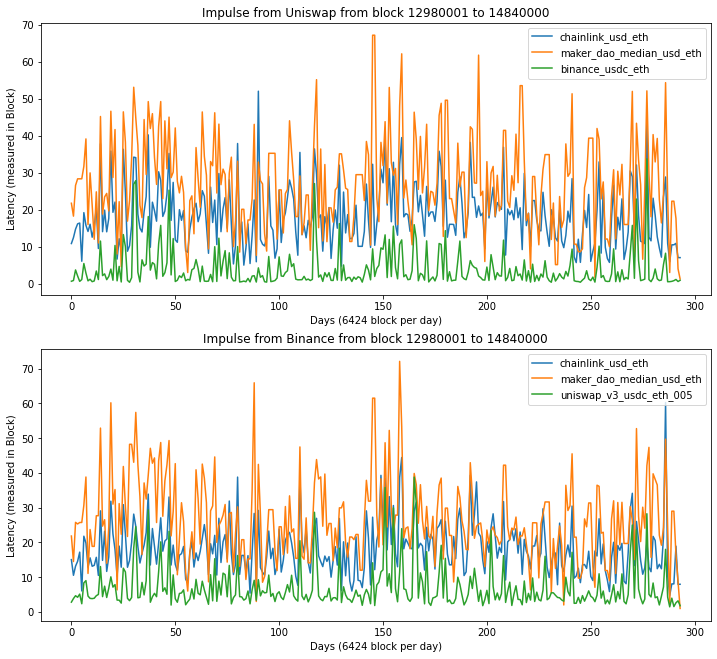

In [35]:


latency_df = get_latency_df("uniswap_v3_usdc_eth_005", ["chainlink_usd_eth", "maker_dao_median_usd_eth", "binance_usdc_eth"], var_irf_list)
latency_df2 = get_latency_df("binance_usdc_eth", ["chainlink_usd_eth", "maker_dao_median_usd_eth", "uniswap_v3_usdc_eth_005"], var_irf_list)


fig,(ax1, ax2) = plt.subplots(2, figsize=(12, 11)) # row 1, col 2 index 1
latency_df.plot(ax=ax1, title='Impulse from Uniswap from block 12980001 to 14840000')
ax1.set(xlabel='Days (6424 block per day)', ylabel='Latency (measured in Block)')

# plt.subplot(1, 2, 2) # index 2
latency_df2.plot(ax=ax2, title='Impulse from Binance from block 12980001 to 14840000')
ax2.set(xlabel='Days (6424 block per day)', ylabel='Latency (measured in Block)')

# plt.figure(figsize=(8, 20), dpi=200)
plt.savefig("LatencyMeasurment.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [5]:
latency_df

,chainlink_usd_eth,maker_dao_median_usd_eth,binance_usdc_eth
0,10.848861,21.757960,0.639868
1,12.458669,18.265608,0.832475
2,14.738032,26.589518,3.697139
3,16.175301,28.365227,2.064264
4,16.396764,28.375447,0.602772
...,...,...,...
289,10.503447,22.315318,0.608330
290,10.503447,22.315318,0.794315
291,10.894401,17.652735,1.120169
292,7.030876,4.000000,0.563437


(<AxesSubplot:>,
 chainlink_usd_eth           18.256992
 maker_dao_median_usd_eth    27.327517
 binance_usdc_eth             3.818251
 dtype: float64)

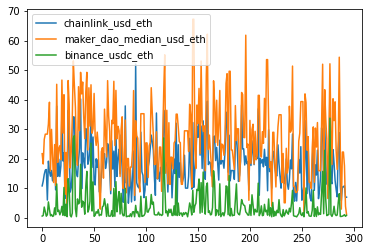

In [4]:
latency_df = get_latency_df("uniswap_v3_usdc_eth_005", ["chainlink_usd_eth", "maker_dao_median_usd_eth", "binance_usdc_eth"], var_irf_list)
latency_df.plot(), latency_df.agg("mean")

In [26]:
for i in ["chainlink_usd_eth","uniswap_v3_usdc_eth_005", "maker_dao_median_usd_eth", "binance_usdc_eth"]:
    latency_df = get_latency_df(i, ["chainlink_usd_eth","uniswap_v3_usdc_eth_005", "maker_dao_median_usd_eth", "binance_usdc_eth"], var_irf_list)
    print(f'Source : {i}')
    print(latency_df.agg("mean"))

Source : chainlink_usd_eth
chainlink_usd_eth            3.698729
uniswap_v3_usdc_eth_005     23.386877
maker_dao_median_usd_eth    21.180748
binance_usdc_eth            21.463996
dtype: float64
Source : uniswap_v3_usdc_eth_005
chainlink_usd_eth           18.282275
uniswap_v3_usdc_eth_005      3.381721
maker_dao_median_usd_eth    27.346526
binance_usdc_eth             3.829099
dtype: float64
Source : maker_dao_median_usd_eth
chainlink_usd_eth           22.563024
uniswap_v3_usdc_eth_005     25.250567
maker_dao_median_usd_eth     2.699600
binance_usdc_eth            23.107727
dtype: float64
Source : binance_usdc_eth
chainlink_usd_eth           18.178068
uniswap_v3_usdc_eth_005      6.860555
maker_dao_median_usd_eth    26.505294
binance_usdc_eth             2.404062
dtype: float64


(<AxesSubplot:>,
 chainlink_usd_eth           62.207509
 maker_dao_median_usd_eth    70.862644
 dtype: float64)

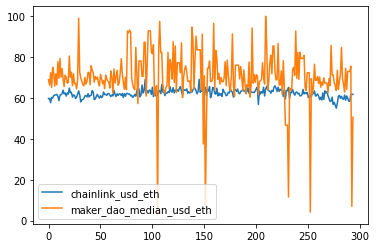

In [29]:
latency_df = get_latency_df("uniswap_v3_usdc_eth_005", ["chainlink_usd_eth", "maker_dao_median_usd_eth"], vecm_irf_list)
latency_df.plot(), latency_df.agg("mean")

(<AxesSubplot:>,
 chainlink_usd_eth           18.178068
 maker_dao_median_usd_eth    26.505294
 uniswap_v3_usdc_eth_005      6.860555
 dtype: float64)

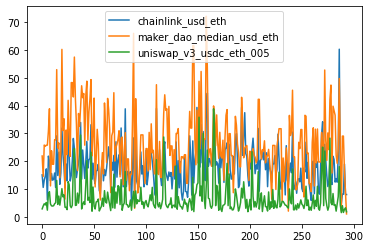

In [24]:
latency_df = get_latency_df("binance_usdc_eth", ["chainlink_usd_eth", "maker_dao_median_usd_eth", "uniswap_v3_usdc_eth_005"], var_irf_list)
latency_df.plot(), latency_df.agg("mean")

(<AxesSubplot:>,
 chainlink_usd_eth           59.528078
 maker_dao_median_usd_eth    56.808596
 dtype: float64)

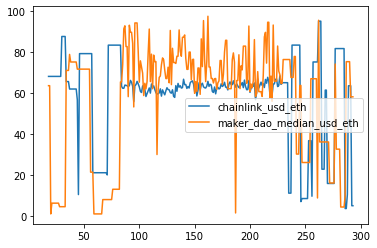

In [31]:
latency_df = get_latency_df("binance_usdc_eth", ["chainlink_usd_eth", "maker_dao_median_usd_eth"], vecm_irf_list)
latency_df.plot(), latency_df.agg("mean")

(<AxesSubplot:>,
 binance_usdc_eth            62.465401
 chainlink_usd_eth           62.207509
 maker_dao_median_usd_eth    70.862644
 dtype: float64)

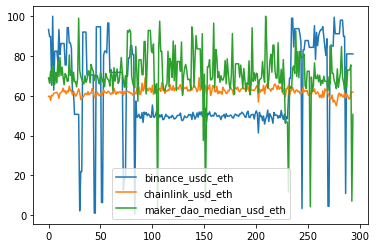

In [32]:
latency_df = get_latency_df("uniswap_v3_usdc_eth_005", ["binance_usdc_eth","chainlink_usd_eth", "maker_dao_median_usd_eth"], vecm_irf_list)
latency_df.plot(), latency_df.agg("mean")

(<AxesSubplot:title={'center':'latency compare to uniswap v3 (var)'}, xlabel='block num (6424 * x) from # 13980001', ylabel='block latency'>,
 binance_usdc_eth            15.047265
 chainlink_usd_eth           15.782174
 maker_dao_median_usd_eth    25.474507
 dtype: float64)

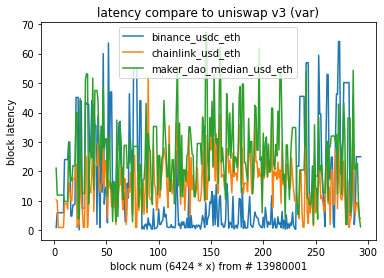

In [38]:
latency_df = get_latency_df("uniswap_v3_usdc_eth_005", ["binance_usdc_eth", "chainlink_usd_eth", "maker_dao_median_usd_eth"], var_irf_list)
latency_df.plot(title='latency compare to uniswap v3 (var)', ylabel='block latency', xlabel='block num (6424 * x) from # 13980001'), latency_df.agg("mean")

(<AxesSubplot:title={'center':'latency compare to binance (var)'}, xlabel='block num (10,000) from # 13980001', ylabel='block latency'>,
 chainlink_usd_eth           21.191550
 maker_dao_median_usd_eth    24.210753
 uniswap_v3_usdc_eth_005     13.209301
 dtype: float64)

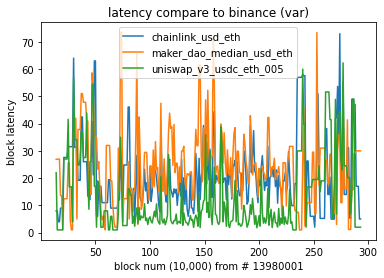

In [34]:
latency_df = get_latency_df("binance_usdc_eth", ["chainlink_usd_eth", "maker_dao_median_usd_eth", "uniswap_v3_usdc_eth_005"], var_irf_list)
latency_df.plot(title='latency compare to binance (var)', ylabel='block latency', xlabel='block num (10,000) from # 13980001'), latency_df.agg("mean")